# Imports

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import namedtuple
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Data loading and preprocessing

## Load the data

#### This time, the data will correspond to greyscale images. <br> Two different datasets can be used here:
- The MNIST dataset, small 8*8 images, corresponding to handwritten digits &rightarrow; 10 classes
- The Fashion MNIST dataset, medium 28*28 images, corresponding to clothes pictures &rightarrow; 10 classes

#### Starting with the simple MNIST is recommended

In [24]:
dataset = "MNIST"
# dataset = "FASHION_MNIST"

In [25]:
def load_data(dataset='MNIST'):
    if dataset == 'MNIST':
        digits = load_digits()
        X, Y = np.asarray(digits['data'], dtype='float32'), np.asarray(digits['target'], dtype='int32')
        return X, Y
    elif dataset == 'FASHION_MNIST':
        import tensorflow as tf
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (X, Y), (_, _) = fashion_mnist.load_data()
        X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
        X, Y = np.asarray(X, dtype='float32'), np.asarray(Y, dtype='int32')
        return X, Y
X, Y = load_data(dataset=dataset)

In [26]:
n_classes = len(np.unique(Y))

In [27]:
print('Number of samples: {:d}'.format(X.shape[0]))
print('Input dimension: {:d}'.format(X.shape[1])) # images 8x8 or 28*28 actually
print('Number of classes: {:d}'.format(n_classes))

Number of samples: 1797
Input dimension: 64
Number of classes: 10


In [28]:
print("Range max-min of greyscale pixel values: ({0:.1f}, {1:.1f})".format(np.max(X), np.min(X)))
print("First image sample:\n{0}".format(X[0]))
print("First image label: {0}".format(Y[0]))
print("Input design matrix shape: {0}".format(X.shape))

Range max-min of greyscale pixel values: (16.0, 0.0)
First image sample:
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
First image label: 0
Input design matrix shape: (1797, 64)


### What does the data look like?
Each image in the dataset consists of a 8 x 8 (or 28 x 28) matrix, of greyscale pixels. For the MNIST dataset, the values are between 0 and 16 where 0 represents white, 16 represents black and there are many shades of grey in-between. For the Fashion MNIST dataset, the values are between 0 and 255.<br>Each image is assigned a corresponding numerical label, so the image in ```X[i]``` has its corresponding label stored in ```Y[i]```.

The next cells below demonstrate how to visualise the input data. Make sure you understand what's happening, particularly how the indices correspond to individual items in the dataset. 

## Visualize the data

In [29]:
def visualize_data_sample(X, Y, nrows=2, ncols=2):
    fig, ax = plt.subplots(nrows, ncols)
    for row in ax:
        for col in row:
            index = random.randint(0, X.shape[0])
            dim = np.sqrt(X.shape[1]).astype(int)
            col.imshow(X[index].reshape((dim, dim)), cmap=plt.cm.gray_r)
            col.set_title("image label: %d" % Y[index])
    plt.tight_layout()
    plt.show()

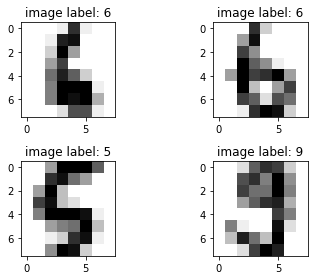

In [30]:
visualize_data_sample(X, Y)

# II - Multiclass classification MLP with Numpy

## II a) - Problem definition

<img src="../images/mlp_mnist.svg">

The task here will be to implement "from scratch" a Multilayer Perceptron for classification.

We will define the formal categorical cross entropy loss as follows:
$$
l(\mathbf{\Theta}, \mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \sum_{i=1}^n \log \mathbf{f}(\mathbf{x}^i ; \mathbf{\Theta})^\top y^i
$$
<center>with $y^i$ being the one-hot encoded true label for the sample $i$, and $\Theta = (\mathbf{W}^h; \mathbf{b}^h; \mathbf{W}^o; \mathbf{b}^o)$</center>
<center>In addition, $\mathbf{f}(\mathbf{x}) = softmax(\mathbf{z^o}(\mathbf{x})) = softmax(\mathbf{W}^o\mathbf{h}(\mathbf{x}) + \mathbf{b}^o)$</center>
<center>and $\mathbf{h}(\mathbf{x}) = g(\mathbf{z^h}(\mathbf{x})) = g(\mathbf{W}^h\mathbf{x} + \mathbf{b}^h)$, $g$ being the activation function and could be implemented with $sigmoid$ or $relu$</center>

## Objectives:
- Write the categorical cross entropy loss function
- Write the activation functions with their associated gradient
- Write the softmax function that is going to be used to output the predicted probabilities
- Implement the forward pass through the neural network
- Implement the backpropagation according to the used loss: progagate the gradients using the chain rule and return $(\mathbf{\nabla_{W^h}}l ; \mathbf{\nabla_{b^h}}l ; \mathbf{\nabla_{W^o}}l ; \mathbf{\nabla_{b^o}}l)$
- Implement dropout regularization in the forward pass: be careful to consider both training and prediction cases
- Implement the SGD optimization algorithm, and improve it with simple momentum

#### Simple graph function to let you have a global overview:

<img src="../images/function_graph.png" style="width: 750px;"/>

## II b) - Implementation

In [74]:
class MultiLayerPerceptron():
    """MLP with one hidden layer having a hidden activation,
    and one output layer having a softmax activation"""
    def __init__(self, X, Y, hidden_size, activation='relu',
                 initialization='uniform', dropout=False, dropout_rate=0):
        # input, hidden, and output dimensions on the MLP based on X, Y
        self.input_size, self.output_size = X.shape[1], len(np.unique(Y))
        self.hidden_size = hidden_size
        # initialization strategies: avoid a full-0 initialization of the weight matrices
        if initialization == 'uniform':
            self.W_h = np.random.uniform(size=(self.input_size, self.hidden_size), high=0.01, low=-0.01)
            self.W_o = np.random.uniform(size=(self.hidden_size, self.output_size), high=0.01, low=-0.01)
        elif initialization == 'normal':
            self.W_h = np.random.normal(size=(self.input_size, self.hidden_size), loc=0, scale=0.01)
            self.W_o = np.random.normal(size=(self.hidden_size, self.output_size), loc=0, scale=0.01)
        # the bias could be initializated to 0 or a random low constant
        self.b_h = np.zeros(self.hidden_size)
        self.b_o = np.zeros(self.output_size)
        # our namedtuple structure of gradients
        self.Grads = namedtuple('Grads', ['W_h', 'b_h', 'W_o', 'b_o'])
        # and the velocities associated which are going to be useful for the momentum
        self.velocities = {'W_h': 0., 'b_h': 0., 'W_o': 0., 'b_o': 0.}
        # the hidden activation function used
        self.activation = activation
        # arrays to track back the losses and accuracies evolution
        self.training_losses_history = []
        self.validation_losses_history = []
        self.validation_acc_history = []
        # train val split and normalization of the features
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
        self.X_tr = self.scaler.fit_transform(self.X_tr)
        self.X_val = self.scaler.transform(self.X_val)
        # dropout parameters
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        # step used for the optimization algorithm and setted later
        self.step = None
    
    # One-hot encoding of the target
    # Transform the integer represensation to a sparse one
    @staticmethod
    def one_hot(n_classes, Y):
        return np.eye(n_classes)[Y]
    
    # Reverse one-hot encoding of the target
    # Recover the former integer representation
    # ex: from (0,0,1,0) to 2
    @staticmethod
    def reverse_one_hot(Y_one_hot):
        return np.asarray(np.where(Y_one_hot==1)[1], dtype='int32')
    
    """
    Activation functions and their gradient
    """
    # In implementations below X is a matrix of shape (n_samples, p)
    
    # A max_value value is indicated for the relu and grad_relu functions
    # Make sure to clip the output to it to prevent numerical overflow (exploding gradient)
    # Make it so the max value reachable is max_value
    @staticmethod
    def relu(X, max_value=20):
        assert max_value > 0
        return np.minimum(np.maximum(X, 0), max_value)
    
    # Make it so the gradient becomes 0 when X becomes greater than max_value
    @staticmethod
    def grad_relu(X, max_value=20):
        return ((X > 0) & (X < max_value)).astype('int32')
    
    @staticmethod
    def sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    def grad_sigmoid(self, X):
        return self.sigmoid(X) * (1 - self.sigmoid(X))
    
    # Softmax function to output probabilities
    @staticmethod
    def softmax(X):
        exp = np.exp(X)
        return exp / np.sum(exp, axis=-1, keepdims=True)
    
    # Loss function
    # Consider using EPSILON to prevent numerical issues (log(0) is undefined)
    # Y_true and Y_pred are of shape (n_samples,n_classes)
    @staticmethod
    def categorical_cross_entropy(Y_true, Y_pred):
        loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
        result = -np.mean(loglikelihoods)
        return result
    
    @staticmethod
    def split_train_validation(X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
    
    # Sample random batch in (X, Y) with a given batch_size for SGD
    @staticmethod
    def get_random_batch(X, Y, batch_size):
        indexes = np.random.choice(X.shape[0], size=batch_size, replace=False)
        return X[indexes], Y[indexes]
        
    # Forward pass: compute f(x) as y, and return optionally the hidden states h(x) and z_h(x) for compute_grads
    def forward(self, X, return_activation=False, training=False):
        if self.activation == 'relu':
            g_activation = self.relu
        elif self.activation == 'sigmoid':
            g_activation = self.sigmoid
        else:
            raise NotImplementedError
    
        z_h = np.dot(X, self.W_h) + self.b_h
        h = g_activation(z_h)
        if self.dropout:
            if training:
                dropout_mask = np.random.binomial(1, 1-self.dropout_rate, size=h.shape)
                h *= dropout_mask
            else:
                h *= (1-self.dropout_rate)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = self.softmax(z_o)
            
        if return_activation:
            return y, h, z_h
        else:
            return y
    
    # Backpropagation: return an instantiation of self.Grads that contains the average gradients for the given batch
    def compute_grads(self, X, Y_true, vectorized=False):
        if self.activation == 'relu':
            g_grad = self.grad_relu
        elif self.activation == 'sigmoid':
            g_grad = self.grad_sigmoid
        else:
            raise NotImplementedError
        
        if len(X.shape) == 1:
            X = X.reshape((1,) + X.shape)
        
        if not vectorized:
            n = X.shape[0]
            grad_W_h = np.zeros((self.input_size, self.hidden_size))
            grad_b_h = np.zeros((self.hidden_size, )) 
            grad_W_o = np.zeros((self.hidden_size, self.output_size))
            grad_b_o = np.zeros((self.output_size, ))
            for x, y_true in zip(X, Y_true):
                y_pred, h, z_h = self.forward(x, return_activation=True, training=True)
                
                grad_z_o = y_pred - self.one_hot(self.output_size, y_true)
                grad_W_o += np.outer(h, grad_z_o)
                grad_b_o += grad_z_o
                grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
                
                grad_z_h = grad_h * g_grad(z_h)
                grad_W_h += np.outer(x, grad_z_h)
                grad_b_h += grad_z_h
                
            grads = self.Grads(grad_W_h/n, grad_b_h/n, grad_W_o/n, grad_b_o/n)
            
        else: 
            Y_pred, h, z_h = self.forward(X, return_activation=True, training=True)

            grad_z_o = Y_pred - self.one_hot(self.output_size, Y_true)
            grad_W_o = np.matmul(h[:, :, np.newaxis], np.swapaxes(grad_z_o[:, :, np.newaxis], 2, 1))
            grad_b_o = grad_z_o
            grad_h = np.dot(grad_z_o, np.transpose(self.W_o))

            grad_z_h = grad_h * g_grad(z_h)
            grad_W_h = np.matmul(X[:, :, np.newaxis], np.swapaxes(grad_z_h[:, :, np.newaxis], 2, 1))
            grad_b_h = grad_z_h
                    
            grads = self.Grads(
                np.mean(grad_W_h, axis=0),
                np.mean(grad_b_h, axis=0),
                np.mean(grad_W_o, axis=0),
                np.mean(grad_b_o, axis=0)
            )
            
        return grads
    
    # Perform the update of the parameters (W_h, b_h, W_o, b_o) based of their gradient
    def optimizer_step(self, optimizer='gd', momentum=False, momentum_alpha=0.9, 
                       batch_size=None, vectorized=True):
        if optimizer == 'gd':
            grads = self.compute_grads(self.X_tr, self.Y_tr, vectorized=vectorized)
        elif optimizer == 'sgd':
            batch_X_tr, batch_Y_tr = self.get_random_batch(self.X_tr, self.Y_tr, batch_size)
            grads = self.compute_grads(batch_X_tr, batch_Y_tr, vectorized=vectorized)
        else:
            raise NotImplementedError
        if not momentum:
            self.W_h -= self.step * grads.W_h
            self.b_h -= self.step * grads.b_h
            self.W_o -= self.step * grads.W_o
            self.b_o -= self.step * grads.b_o
        else:
            self.velocities['W_h'] = momentum_alpha * self.velocities['W_h'] - self.step * grads.W_h
            self.W_h += self.velocities['W_h']
            self.velocities['b_h'] = momentum_alpha * self.velocities['b_h'] - self.step * grads.b_h
            self.b_h += self.velocities['b_h']
            self.velocities['W_o'] = momentum_alpha * self.velocities['W_o'] - self.step * grads.W_o
            self.W_o += self.velocities['W_o']
            self.velocities['b_o'] = momentum_alpha * self.velocities['b_o'] - self.step * grads.b_o
            self.b_o += self.velocities['b_o']
    
    # Loss wrapper
    def loss(self, Y_true, Y_pred):
        return self.categorical_cross_entropy(self.one_hot(self.output_size, Y_true), Y_pred)
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
        
    # Main function that trains the MLP with a design matrix X and a target vector Y
    def train(self, optimizer='sgd', momentum=False, min_iterations=500, max_iterations=5000, initial_step=1e-1,
              batch_size=64, early_stopping=True, early_stopping_lookbehind=100, early_stopping_delta=1e-4, 
              vectorized=False, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        self.step = initial_step
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.optimizer_step(
                optimizer=optimizer, momentum=momentum, batch_size=batch_size, vectorized=vectorized
            )
            training_loss = self.loss(self.Y_tr, self.forward(self.X_tr))
            self.training_losses_history.append(training_loss)
            validation_loss = self.loss(self.Y_val, self.forward(self.X_val))
            self.validation_losses_history.append(validation_loss)
            validation_accuracy = self.accuracy_on_validation()
            self.validation_acc_history.append(validation_accuracy)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t" + \
                "validation loss: {2:.4f}\t validation accuracy: {3:.4f}"
                print(msg.format(iteration_number, 
                                 training_loss,
                                 validation_loss,
                                 validation_accuracy))
            if cpt_patience >= early_stopping_lookbehind:
                break
    
    # Return the predicted class once the MLP has been trained
    def predict(self, X, normalize=True):
        if normalize:
            X = self.scaler.transform(X)
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
        
    """
    Metrics and plots
    """
    def accuracy_on_train(self):
        return (self.predict(self.X_tr, normalize=False) == self.Y_tr).mean()

    def accuracy_on_validation(self):
        return (self.predict(self.X_val, normalize=False) == self.Y_val).mean()

    def plot_loss_history(self, add_to_title=None):
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)),
                 self.validation_losses_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("Cross entropy loss", fontsize=15)
        base_title = "Cross entropy loss evolution during training"
        if not self.dropout:
            base_title += ", no dropout penalization"
        else:
            base_title += ", {:.2f} dropout penalization"
            base_title = base_title.format(self.dropout_rate)
        title = base_title + ", " + add_to_title if add_to_title else base_title
        plt.title(title, fontsize=20)
        plt.show()
        
    def plot_validation_prediction(self, sample_id):
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        classes = np.unique(self.Y_tr)
        dim = np.sqrt(self.X_val.shape[1]).astype(int)
        ax0.imshow(self.scaler.inverse_transform([self.X_val[sample_id]]).reshape(dim, dim), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        ax0.set_title("True image label: %d" % self.Y_val[sample_id]);

        ax1.bar(classes, self.one_hot(len(classes), self.Y_val[sample_id]), label='true')
        ax1.bar(classes, self.forward(self.X_val[sample_id]), label='prediction', color="red")
        ax1.set_xticks(classes)
        prediction = self.predict(self.X_val[sample_id], normalize=False)
        ax1.set_title('Output probabilities (prediction: %d)' % prediction)
        ax1.set_xlabel('Digit class')
        ax1.legend()

#### Standard MLP

In [39]:
mlp = MultiLayerPerceptron(X, Y, hidden_size=50, activation='relu')
mlp.train(vectorized=True, early_stopping=False)

iteration number: 1	 training loss: 2.3026	validation loss: 2.3025	 validation accuracy: 0.1178
iteration number: 2	 training loss: 2.3026	validation loss: 2.3025	 validation accuracy: 0.1178
iteration number: 3	 training loss: 2.3026	validation loss: 2.3024	 validation accuracy: 0.1178
iteration number: 4	 training loss: 2.3024	validation loss: 2.3029	 validation accuracy: 0.0844
iteration number: 5	 training loss: 2.3025	validation loss: 2.3026	 validation accuracy: 0.0844
iteration number: 6	 training loss: 2.3025	validation loss: 2.3026	 validation accuracy: 0.1111
iteration number: 7	 training loss: 2.3025	validation loss: 2.3027	 validation accuracy: 0.0844
iteration number: 8	 training loss: 2.3025	validation loss: 2.3029	 validation accuracy: 0.0844
iteration number: 9	 training loss: 2.3024	validation loss: 2.3029	 validation accuracy: 0.0844
iteration number: 10	 training loss: 2.3024	validation loss: 2.3028	 validation accuracy: 0.0844
iteration number: 11	 training loss: 2.

iteration number: 92	 training loss: 2.2888	validation loss: 2.2942	 validation accuracy: 0.0778
iteration number: 93	 training loss: 2.2883	validation loss: 2.2935	 validation accuracy: 0.0778
iteration number: 94	 training loss: 2.2877	validation loss: 2.2929	 validation accuracy: 0.0778
iteration number: 95	 training loss: 2.2870	validation loss: 2.2928	 validation accuracy: 0.0778
iteration number: 96	 training loss: 2.2865	validation loss: 2.2922	 validation accuracy: 0.0778
iteration number: 97	 training loss: 2.2860	validation loss: 2.2914	 validation accuracy: 0.0778
iteration number: 98	 training loss: 2.2853	validation loss: 2.2909	 validation accuracy: 0.0778
iteration number: 99	 training loss: 2.2846	validation loss: 2.2906	 validation accuracy: 0.0778
iteration number: 100	 training loss: 2.2840	validation loss: 2.2901	 validation accuracy: 0.0778
iteration number: 101	 training loss: 2.2833	validation loss: 2.2893	 validation accuracy: 0.0778
iteration number: 102	 train

iteration number: 182	 training loss: 1.9536	validation loss: 1.9865	 validation accuracy: 0.3600
iteration number: 183	 training loss: 1.9441	validation loss: 1.9783	 validation accuracy: 0.4000
iteration number: 184	 training loss: 1.9339	validation loss: 1.9690	 validation accuracy: 0.3756
iteration number: 185	 training loss: 1.9245	validation loss: 1.9613	 validation accuracy: 0.3578
iteration number: 186	 training loss: 1.9139	validation loss: 1.9512	 validation accuracy: 0.3689
iteration number: 187	 training loss: 1.9036	validation loss: 1.9410	 validation accuracy: 0.3733
iteration number: 188	 training loss: 1.8934	validation loss: 1.9301	 validation accuracy: 0.3822
iteration number: 189	 training loss: 1.8851	validation loss: 1.9201	 validation accuracy: 0.4200
iteration number: 190	 training loss: 1.8742	validation loss: 1.9099	 validation accuracy: 0.4156
iteration number: 191	 training loss: 1.8653	validation loss: 1.9004	 validation accuracy: 0.4200
iteration number: 19

iteration number: 278	 training loss: 0.9845	validation loss: 1.0189	 validation accuracy: 0.7911
iteration number: 279	 training loss: 0.9792	validation loss: 1.0060	 validation accuracy: 0.7978
iteration number: 280	 training loss: 0.9700	validation loss: 1.0005	 validation accuracy: 0.8022
iteration number: 281	 training loss: 0.9648	validation loss: 0.9914	 validation accuracy: 0.8289
iteration number: 282	 training loss: 0.9566	validation loss: 0.9821	 validation accuracy: 0.8089
iteration number: 283	 training loss: 0.9522	validation loss: 0.9833	 validation accuracy: 0.7644
iteration number: 284	 training loss: 0.9489	validation loss: 0.9768	 validation accuracy: 0.7867
iteration number: 285	 training loss: 0.9365	validation loss: 0.9708	 validation accuracy: 0.7956
iteration number: 286	 training loss: 0.9360	validation loss: 0.9672	 validation accuracy: 0.8244
iteration number: 287	 training loss: 0.9313	validation loss: 0.9617	 validation accuracy: 0.8289
iteration number: 28

iteration number: 373	 training loss: 0.5686	validation loss: 0.5798	 validation accuracy: 0.8667
iteration number: 374	 training loss: 0.5706	validation loss: 0.5812	 validation accuracy: 0.8711
iteration number: 375	 training loss: 0.5688	validation loss: 0.5813	 validation accuracy: 0.8733
iteration number: 376	 training loss: 0.5657	validation loss: 0.5813	 validation accuracy: 0.8733
iteration number: 377	 training loss: 0.5585	validation loss: 0.5702	 validation accuracy: 0.8667
iteration number: 378	 training loss: 0.5552	validation loss: 0.5752	 validation accuracy: 0.8644
iteration number: 379	 training loss: 0.5546	validation loss: 0.5744	 validation accuracy: 0.8667
iteration number: 380	 training loss: 0.5520	validation loss: 0.5739	 validation accuracy: 0.8733
iteration number: 381	 training loss: 0.5483	validation loss: 0.5648	 validation accuracy: 0.8711
iteration number: 382	 training loss: 0.5465	validation loss: 0.5617	 validation accuracy: 0.8822
iteration number: 38

iteration number: 474	 training loss: 0.3875	validation loss: 0.3856	 validation accuracy: 0.9200
iteration number: 475	 training loss: 0.3843	validation loss: 0.3912	 validation accuracy: 0.9111
iteration number: 476	 training loss: 0.3849	validation loss: 0.3900	 validation accuracy: 0.9067
iteration number: 477	 training loss: 0.3842	validation loss: 0.3932	 validation accuracy: 0.9089
iteration number: 478	 training loss: 0.3815	validation loss: 0.3907	 validation accuracy: 0.9044
iteration number: 479	 training loss: 0.3785	validation loss: 0.3892	 validation accuracy: 0.9244
iteration number: 480	 training loss: 0.3791	validation loss: 0.3941	 validation accuracy: 0.9089
iteration number: 481	 training loss: 0.3843	validation loss: 0.3908	 validation accuracy: 0.9289
iteration number: 482	 training loss: 0.3777	validation loss: 0.3884	 validation accuracy: 0.9289
iteration number: 483	 training loss: 0.3781	validation loss: 0.3905	 validation accuracy: 0.9178
iteration number: 48

iteration number: 576	 training loss: 0.2896	validation loss: 0.2974	 validation accuracy: 0.9244
iteration number: 577	 training loss: 0.2909	validation loss: 0.2981	 validation accuracy: 0.9222
iteration number: 578	 training loss: 0.2903	validation loss: 0.3025	 validation accuracy: 0.9289
iteration number: 579	 training loss: 0.2894	validation loss: 0.3054	 validation accuracy: 0.9311
iteration number: 580	 training loss: 0.2887	validation loss: 0.3022	 validation accuracy: 0.9378
iteration number: 581	 training loss: 0.2869	validation loss: 0.2996	 validation accuracy: 0.9267
iteration number: 582	 training loss: 0.2870	validation loss: 0.2953	 validation accuracy: 0.9289
iteration number: 583	 training loss: 0.2839	validation loss: 0.2923	 validation accuracy: 0.9378
iteration number: 584	 training loss: 0.2840	validation loss: 0.2923	 validation accuracy: 0.9267
iteration number: 585	 training loss: 0.2832	validation loss: 0.2905	 validation accuracy: 0.9267
iteration number: 58

iteration number: 686	 training loss: 0.2298	validation loss: 0.2410	 validation accuracy: 0.9356
iteration number: 687	 training loss: 0.2277	validation loss: 0.2408	 validation accuracy: 0.9422
iteration number: 688	 training loss: 0.2290	validation loss: 0.2355	 validation accuracy: 0.9467
iteration number: 689	 training loss: 0.2273	validation loss: 0.2385	 validation accuracy: 0.9444
iteration number: 690	 training loss: 0.2271	validation loss: 0.2412	 validation accuracy: 0.9422
iteration number: 691	 training loss: 0.2298	validation loss: 0.2519	 validation accuracy: 0.9356
iteration number: 692	 training loss: 0.2280	validation loss: 0.2471	 validation accuracy: 0.9356
iteration number: 693	 training loss: 0.2270	validation loss: 0.2449	 validation accuracy: 0.9356
iteration number: 694	 training loss: 0.2285	validation loss: 0.2502	 validation accuracy: 0.9356
iteration number: 695	 training loss: 0.2252	validation loss: 0.2393	 validation accuracy: 0.9422
iteration number: 69

iteration number: 796	 training loss: 0.1906	validation loss: 0.2100	 validation accuracy: 0.9422
iteration number: 797	 training loss: 0.1895	validation loss: 0.2089	 validation accuracy: 0.9422
iteration number: 798	 training loss: 0.1888	validation loss: 0.2061	 validation accuracy: 0.9400
iteration number: 799	 training loss: 0.1874	validation loss: 0.2045	 validation accuracy: 0.9467
iteration number: 800	 training loss: 0.1890	validation loss: 0.2034	 validation accuracy: 0.9489
iteration number: 801	 training loss: 0.1881	validation loss: 0.2071	 validation accuracy: 0.9489
iteration number: 802	 training loss: 0.1881	validation loss: 0.2048	 validation accuracy: 0.9467
iteration number: 803	 training loss: 0.1886	validation loss: 0.2119	 validation accuracy: 0.9444
iteration number: 804	 training loss: 0.1889	validation loss: 0.2022	 validation accuracy: 0.9467
iteration number: 805	 training loss: 0.1943	validation loss: 0.2053	 validation accuracy: 0.9467
iteration number: 80

iteration number: 902	 training loss: 0.1647	validation loss: 0.1763	 validation accuracy: 0.9556
iteration number: 903	 training loss: 0.1657	validation loss: 0.1816	 validation accuracy: 0.9467
iteration number: 904	 training loss: 0.1629	validation loss: 0.1800	 validation accuracy: 0.9578
iteration number: 905	 training loss: 0.1620	validation loss: 0.1828	 validation accuracy: 0.9533
iteration number: 906	 training loss: 0.1615	validation loss: 0.1774	 validation accuracy: 0.9600
iteration number: 907	 training loss: 0.1616	validation loss: 0.1779	 validation accuracy: 0.9578
iteration number: 908	 training loss: 0.1623	validation loss: 0.1768	 validation accuracy: 0.9578
iteration number: 909	 training loss: 0.1626	validation loss: 0.1793	 validation accuracy: 0.9556
iteration number: 910	 training loss: 0.1629	validation loss: 0.1807	 validation accuracy: 0.9556
iteration number: 911	 training loss: 0.1647	validation loss: 0.1878	 validation accuracy: 0.9489
iteration number: 91

iteration number: 1008	 training loss: 0.1438	validation loss: 0.1656	 validation accuracy: 0.9556
iteration number: 1009	 training loss: 0.1425	validation loss: 0.1643	 validation accuracy: 0.9556
iteration number: 1010	 training loss: 0.1421	validation loss: 0.1648	 validation accuracy: 0.9600
iteration number: 1011	 training loss: 0.1421	validation loss: 0.1668	 validation accuracy: 0.9556
iteration number: 1012	 training loss: 0.1425	validation loss: 0.1742	 validation accuracy: 0.9578
iteration number: 1013	 training loss: 0.1425	validation loss: 0.1758	 validation accuracy: 0.9533
iteration number: 1014	 training loss: 0.1422	validation loss: 0.1708	 validation accuracy: 0.9533
iteration number: 1015	 training loss: 0.1422	validation loss: 0.1676	 validation accuracy: 0.9533
iteration number: 1016	 training loss: 0.1413	validation loss: 0.1671	 validation accuracy: 0.9578
iteration number: 1017	 training loss: 0.1424	validation loss: 0.1660	 validation accuracy: 0.9600
iteration 

iteration number: 1107	 training loss: 0.1309	validation loss: 0.1593	 validation accuracy: 0.9578
iteration number: 1108	 training loss: 0.1282	validation loss: 0.1608	 validation accuracy: 0.9533
iteration number: 1109	 training loss: 0.1293	validation loss: 0.1655	 validation accuracy: 0.9511
iteration number: 1110	 training loss: 0.1303	validation loss: 0.1695	 validation accuracy: 0.9467
iteration number: 1111	 training loss: 0.1298	validation loss: 0.1686	 validation accuracy: 0.9511
iteration number: 1112	 training loss: 0.1283	validation loss: 0.1635	 validation accuracy: 0.9511
iteration number: 1113	 training loss: 0.1291	validation loss: 0.1629	 validation accuracy: 0.9556
iteration number: 1114	 training loss: 0.1281	validation loss: 0.1572	 validation accuracy: 0.9556
iteration number: 1115	 training loss: 0.1282	validation loss: 0.1583	 validation accuracy: 0.9600
iteration number: 1116	 training loss: 0.1283	validation loss: 0.1568	 validation accuracy: 0.9622
iteration 

iteration number: 1207	 training loss: 0.1168	validation loss: 0.1506	 validation accuracy: 0.9622
iteration number: 1208	 training loss: 0.1172	validation loss: 0.1510	 validation accuracy: 0.9600
iteration number: 1209	 training loss: 0.1187	validation loss: 0.1533	 validation accuracy: 0.9578
iteration number: 1210	 training loss: 0.1181	validation loss: 0.1536	 validation accuracy: 0.9600
iteration number: 1211	 training loss: 0.1171	validation loss: 0.1496	 validation accuracy: 0.9644
iteration number: 1212	 training loss: 0.1176	validation loss: 0.1517	 validation accuracy: 0.9622
iteration number: 1213	 training loss: 0.1175	validation loss: 0.1529	 validation accuracy: 0.9622
iteration number: 1214	 training loss: 0.1169	validation loss: 0.1487	 validation accuracy: 0.9644
iteration number: 1215	 training loss: 0.1173	validation loss: 0.1503	 validation accuracy: 0.9644
iteration number: 1216	 training loss: 0.1162	validation loss: 0.1480	 validation accuracy: 0.9644
iteration 

iteration number: 1293	 training loss: 0.1086	validation loss: 0.1434	 validation accuracy: 0.9644
iteration number: 1294	 training loss: 0.1084	validation loss: 0.1466	 validation accuracy: 0.9578
iteration number: 1295	 training loss: 0.1087	validation loss: 0.1504	 validation accuracy: 0.9578
iteration number: 1296	 training loss: 0.1104	validation loss: 0.1547	 validation accuracy: 0.9578
iteration number: 1297	 training loss: 0.1113	validation loss: 0.1568	 validation accuracy: 0.9556
iteration number: 1298	 training loss: 0.1094	validation loss: 0.1498	 validation accuracy: 0.9556
iteration number: 1299	 training loss: 0.1090	validation loss: 0.1465	 validation accuracy: 0.9600
iteration number: 1300	 training loss: 0.1093	validation loss: 0.1493	 validation accuracy: 0.9600
iteration number: 1301	 training loss: 0.1092	validation loss: 0.1485	 validation accuracy: 0.9600
iteration number: 1302	 training loss: 0.1083	validation loss: 0.1450	 validation accuracy: 0.9578
iteration 

iteration number: 1412	 training loss: 0.1029	validation loss: 0.1366	 validation accuracy: 0.9689
iteration number: 1413	 training loss: 0.0991	validation loss: 0.1379	 validation accuracy: 0.9622
iteration number: 1414	 training loss: 0.0993	validation loss: 0.1382	 validation accuracy: 0.9644
iteration number: 1415	 training loss: 0.0996	validation loss: 0.1401	 validation accuracy: 0.9644
iteration number: 1416	 training loss: 0.0997	validation loss: 0.1418	 validation accuracy: 0.9600
iteration number: 1417	 training loss: 0.0992	validation loss: 0.1411	 validation accuracy: 0.9600
iteration number: 1418	 training loss: 0.1002	validation loss: 0.1442	 validation accuracy: 0.9578
iteration number: 1419	 training loss: 0.1005	validation loss: 0.1438	 validation accuracy: 0.9600
iteration number: 1420	 training loss: 0.0999	validation loss: 0.1450	 validation accuracy: 0.9578
iteration number: 1421	 training loss: 0.0999	validation loss: 0.1469	 validation accuracy: 0.9556
iteration 

iteration number: 1512	 training loss: 0.0921	validation loss: 0.1356	 validation accuracy: 0.9600
iteration number: 1513	 training loss: 0.0926	validation loss: 0.1329	 validation accuracy: 0.9600
iteration number: 1514	 training loss: 0.0923	validation loss: 0.1313	 validation accuracy: 0.9667
iteration number: 1515	 training loss: 0.0926	validation loss: 0.1310	 validation accuracy: 0.9667
iteration number: 1516	 training loss: 0.0929	validation loss: 0.1314	 validation accuracy: 0.9667
iteration number: 1517	 training loss: 0.0916	validation loss: 0.1295	 validation accuracy: 0.9689
iteration number: 1518	 training loss: 0.0917	validation loss: 0.1298	 validation accuracy: 0.9689
iteration number: 1519	 training loss: 0.0923	validation loss: 0.1278	 validation accuracy: 0.9689
iteration number: 1520	 training loss: 0.0924	validation loss: 0.1267	 validation accuracy: 0.9689
iteration number: 1521	 training loss: 0.0923	validation loss: 0.1274	 validation accuracy: 0.9689
iteration 

iteration number: 1609	 training loss: 0.0866	validation loss: 0.1276	 validation accuracy: 0.9667
iteration number: 1610	 training loss: 0.0865	validation loss: 0.1277	 validation accuracy: 0.9644
iteration number: 1611	 training loss: 0.0864	validation loss: 0.1274	 validation accuracy: 0.9622
iteration number: 1612	 training loss: 0.0888	validation loss: 0.1254	 validation accuracy: 0.9644
iteration number: 1613	 training loss: 0.0885	validation loss: 0.1275	 validation accuracy: 0.9644
iteration number: 1614	 training loss: 0.0889	validation loss: 0.1258	 validation accuracy: 0.9644
iteration number: 1615	 training loss: 0.0897	validation loss: 0.1260	 validation accuracy: 0.9667
iteration number: 1616	 training loss: 0.0873	validation loss: 0.1273	 validation accuracy: 0.9667
iteration number: 1617	 training loss: 0.0877	validation loss: 0.1278	 validation accuracy: 0.9667
iteration number: 1618	 training loss: 0.0880	validation loss: 0.1288	 validation accuracy: 0.9644
iteration 

iteration number: 1711	 training loss: 0.0811	validation loss: 0.1274	 validation accuracy: 0.9644
iteration number: 1712	 training loss: 0.0809	validation loss: 0.1259	 validation accuracy: 0.9667
iteration number: 1713	 training loss: 0.0813	validation loss: 0.1235	 validation accuracy: 0.9667
iteration number: 1714	 training loss: 0.0808	validation loss: 0.1217	 validation accuracy: 0.9711
iteration number: 1715	 training loss: 0.0819	validation loss: 0.1214	 validation accuracy: 0.9667
iteration number: 1716	 training loss: 0.0808	validation loss: 0.1241	 validation accuracy: 0.9644
iteration number: 1717	 training loss: 0.0804	validation loss: 0.1277	 validation accuracy: 0.9644
iteration number: 1718	 training loss: 0.0829	validation loss: 0.1257	 validation accuracy: 0.9689
iteration number: 1719	 training loss: 0.0843	validation loss: 0.1235	 validation accuracy: 0.9711
iteration number: 1720	 training loss: 0.0828	validation loss: 0.1219	 validation accuracy: 0.9711
iteration 

iteration number: 1811	 training loss: 0.0774	validation loss: 0.1263	 validation accuracy: 0.9622
iteration number: 1812	 training loss: 0.0772	validation loss: 0.1275	 validation accuracy: 0.9622
iteration number: 1813	 training loss: 0.0781	validation loss: 0.1293	 validation accuracy: 0.9600
iteration number: 1814	 training loss: 0.0767	validation loss: 0.1224	 validation accuracy: 0.9644
iteration number: 1815	 training loss: 0.0764	validation loss: 0.1214	 validation accuracy: 0.9644
iteration number: 1816	 training loss: 0.0762	validation loss: 0.1210	 validation accuracy: 0.9667
iteration number: 1817	 training loss: 0.0761	validation loss: 0.1215	 validation accuracy: 0.9644
iteration number: 1818	 training loss: 0.0765	validation loss: 0.1210	 validation accuracy: 0.9667
iteration number: 1819	 training loss: 0.0768	validation loss: 0.1190	 validation accuracy: 0.9711
iteration number: 1820	 training loss: 0.0783	validation loss: 0.1205	 validation accuracy: 0.9689
iteration 

iteration number: 1905	 training loss: 0.0723	validation loss: 0.1214	 validation accuracy: 0.9689
iteration number: 1906	 training loss: 0.0723	validation loss: 0.1255	 validation accuracy: 0.9667
iteration number: 1907	 training loss: 0.0719	validation loss: 0.1217	 validation accuracy: 0.9667
iteration number: 1908	 training loss: 0.0724	validation loss: 0.1192	 validation accuracy: 0.9644
iteration number: 1909	 training loss: 0.0727	validation loss: 0.1192	 validation accuracy: 0.9644
iteration number: 1910	 training loss: 0.0738	validation loss: 0.1201	 validation accuracy: 0.9667
iteration number: 1911	 training loss: 0.0731	validation loss: 0.1195	 validation accuracy: 0.9689
iteration number: 1912	 training loss: 0.0734	validation loss: 0.1214	 validation accuracy: 0.9733
iteration number: 1913	 training loss: 0.0729	validation loss: 0.1260	 validation accuracy: 0.9667
iteration number: 1914	 training loss: 0.0741	validation loss: 0.1263	 validation accuracy: 0.9644
iteration 

iteration number: 1997	 training loss: 0.0692	validation loss: 0.1244	 validation accuracy: 0.9689
iteration number: 1998	 training loss: 0.0701	validation loss: 0.1268	 validation accuracy: 0.9644
iteration number: 1999	 training loss: 0.0714	validation loss: 0.1232	 validation accuracy: 0.9711
iteration number: 2000	 training loss: 0.0700	validation loss: 0.1223	 validation accuracy: 0.9711
iteration number: 2001	 training loss: 0.0705	validation loss: 0.1232	 validation accuracy: 0.9711
iteration number: 2002	 training loss: 0.0706	validation loss: 0.1217	 validation accuracy: 0.9711
iteration number: 2003	 training loss: 0.0730	validation loss: 0.1193	 validation accuracy: 0.9756
iteration number: 2004	 training loss: 0.0733	validation loss: 0.1189	 validation accuracy: 0.9756
iteration number: 2005	 training loss: 0.0727	validation loss: 0.1179	 validation accuracy: 0.9756
iteration number: 2006	 training loss: 0.0727	validation loss: 0.1178	 validation accuracy: 0.9733
iteration 

iteration number: 2099	 training loss: 0.0659	validation loss: 0.1184	 validation accuracy: 0.9689
iteration number: 2100	 training loss: 0.0659	validation loss: 0.1198	 validation accuracy: 0.9689
iteration number: 2101	 training loss: 0.0664	validation loss: 0.1185	 validation accuracy: 0.9711
iteration number: 2102	 training loss: 0.0684	validation loss: 0.1179	 validation accuracy: 0.9689
iteration number: 2103	 training loss: 0.0664	validation loss: 0.1170	 validation accuracy: 0.9689
iteration number: 2104	 training loss: 0.0657	validation loss: 0.1176	 validation accuracy: 0.9689
iteration number: 2105	 training loss: 0.0655	validation loss: 0.1202	 validation accuracy: 0.9711
iteration number: 2106	 training loss: 0.0655	validation loss: 0.1194	 validation accuracy: 0.9689
iteration number: 2107	 training loss: 0.0654	validation loss: 0.1188	 validation accuracy: 0.9689
iteration number: 2108	 training loss: 0.0654	validation loss: 0.1202	 validation accuracy: 0.9711
iteration 

iteration number: 2205	 training loss: 0.0632	validation loss: 0.1218	 validation accuracy: 0.9644
iteration number: 2206	 training loss: 0.0631	validation loss: 0.1206	 validation accuracy: 0.9644
iteration number: 2207	 training loss: 0.0628	validation loss: 0.1200	 validation accuracy: 0.9644
iteration number: 2208	 training loss: 0.0631	validation loss: 0.1211	 validation accuracy: 0.9667
iteration number: 2209	 training loss: 0.0637	validation loss: 0.1184	 validation accuracy: 0.9667
iteration number: 2210	 training loss: 0.0638	validation loss: 0.1180	 validation accuracy: 0.9667
iteration number: 2211	 training loss: 0.0626	validation loss: 0.1163	 validation accuracy: 0.9667
iteration number: 2212	 training loss: 0.0641	validation loss: 0.1161	 validation accuracy: 0.9667
iteration number: 2213	 training loss: 0.0629	validation loss: 0.1140	 validation accuracy: 0.9667
iteration number: 2214	 training loss: 0.0629	validation loss: 0.1163	 validation accuracy: 0.9667
iteration 

iteration number: 2313	 training loss: 0.0629	validation loss: 0.1140	 validation accuracy: 0.9711
iteration number: 2314	 training loss: 0.0620	validation loss: 0.1161	 validation accuracy: 0.9689
iteration number: 2315	 training loss: 0.0601	validation loss: 0.1176	 validation accuracy: 0.9622
iteration number: 2316	 training loss: 0.0600	validation loss: 0.1190	 validation accuracy: 0.9622
iteration number: 2317	 training loss: 0.0610	validation loss: 0.1168	 validation accuracy: 0.9667
iteration number: 2318	 training loss: 0.0605	validation loss: 0.1172	 validation accuracy: 0.9667
iteration number: 2319	 training loss: 0.0626	validation loss: 0.1182	 validation accuracy: 0.9644
iteration number: 2320	 training loss: 0.0609	validation loss: 0.1147	 validation accuracy: 0.9667
iteration number: 2321	 training loss: 0.0599	validation loss: 0.1144	 validation accuracy: 0.9689
iteration number: 2322	 training loss: 0.0595	validation loss: 0.1106	 validation accuracy: 0.9711
iteration 

iteration number: 2396	 training loss: 0.0573	validation loss: 0.1146	 validation accuracy: 0.9689
iteration number: 2397	 training loss: 0.0571	validation loss: 0.1155	 validation accuracy: 0.9689
iteration number: 2398	 training loss: 0.0569	validation loss: 0.1148	 validation accuracy: 0.9644
iteration number: 2399	 training loss: 0.0573	validation loss: 0.1159	 validation accuracy: 0.9667
iteration number: 2400	 training loss: 0.0587	validation loss: 0.1169	 validation accuracy: 0.9622
iteration number: 2401	 training loss: 0.0575	validation loss: 0.1111	 validation accuracy: 0.9667
iteration number: 2402	 training loss: 0.0576	validation loss: 0.1112	 validation accuracy: 0.9689
iteration number: 2403	 training loss: 0.0584	validation loss: 0.1103	 validation accuracy: 0.9667
iteration number: 2404	 training loss: 0.0589	validation loss: 0.1115	 validation accuracy: 0.9667
iteration number: 2405	 training loss: 0.0569	validation loss: 0.1161	 validation accuracy: 0.9667
iteration 

iteration number: 2488	 training loss: 0.0554	validation loss: 0.1164	 validation accuracy: 0.9689
iteration number: 2489	 training loss: 0.0556	validation loss: 0.1184	 validation accuracy: 0.9667
iteration number: 2490	 training loss: 0.0563	validation loss: 0.1167	 validation accuracy: 0.9689
iteration number: 2491	 training loss: 0.0562	validation loss: 0.1179	 validation accuracy: 0.9644
iteration number: 2492	 training loss: 0.0562	validation loss: 0.1171	 validation accuracy: 0.9622
iteration number: 2493	 training loss: 0.0552	validation loss: 0.1146	 validation accuracy: 0.9644
iteration number: 2494	 training loss: 0.0549	validation loss: 0.1163	 validation accuracy: 0.9644
iteration number: 2495	 training loss: 0.0555	validation loss: 0.1142	 validation accuracy: 0.9600
iteration number: 2496	 training loss: 0.0554	validation loss: 0.1138	 validation accuracy: 0.9622
iteration number: 2497	 training loss: 0.0552	validation loss: 0.1167	 validation accuracy: 0.9644
iteration 

iteration number: 2573	 training loss: 0.0548	validation loss: 0.1125	 validation accuracy: 0.9711
iteration number: 2574	 training loss: 0.0541	validation loss: 0.1120	 validation accuracy: 0.9667
iteration number: 2575	 training loss: 0.0543	validation loss: 0.1124	 validation accuracy: 0.9689
iteration number: 2576	 training loss: 0.0541	validation loss: 0.1145	 validation accuracy: 0.9689
iteration number: 2577	 training loss: 0.0540	validation loss: 0.1120	 validation accuracy: 0.9711
iteration number: 2578	 training loss: 0.0540	validation loss: 0.1133	 validation accuracy: 0.9667
iteration number: 2579	 training loss: 0.0541	validation loss: 0.1153	 validation accuracy: 0.9667
iteration number: 2580	 training loss: 0.0531	validation loss: 0.1137	 validation accuracy: 0.9667
iteration number: 2581	 training loss: 0.0529	validation loss: 0.1100	 validation accuracy: 0.9711
iteration number: 2582	 training loss: 0.0531	validation loss: 0.1112	 validation accuracy: 0.9711
iteration 

iteration number: 2665	 training loss: 0.0510	validation loss: 0.1138	 validation accuracy: 0.9644
iteration number: 2666	 training loss: 0.0508	validation loss: 0.1122	 validation accuracy: 0.9667
iteration number: 2667	 training loss: 0.0508	validation loss: 0.1134	 validation accuracy: 0.9667
iteration number: 2668	 training loss: 0.0508	validation loss: 0.1134	 validation accuracy: 0.9689
iteration number: 2669	 training loss: 0.0506	validation loss: 0.1137	 validation accuracy: 0.9689
iteration number: 2670	 training loss: 0.0506	validation loss: 0.1127	 validation accuracy: 0.9689
iteration number: 2671	 training loss: 0.0507	validation loss: 0.1148	 validation accuracy: 0.9689
iteration number: 2672	 training loss: 0.0510	validation loss: 0.1123	 validation accuracy: 0.9711
iteration number: 2673	 training loss: 0.0510	validation loss: 0.1114	 validation accuracy: 0.9689
iteration number: 2674	 training loss: 0.0516	validation loss: 0.1117	 validation accuracy: 0.9644
iteration 

iteration number: 2760	 training loss: 0.0492	validation loss: 0.1101	 validation accuracy: 0.9667
iteration number: 2761	 training loss: 0.0494	validation loss: 0.1107	 validation accuracy: 0.9711
iteration number: 2762	 training loss: 0.0493	validation loss: 0.1107	 validation accuracy: 0.9689
iteration number: 2763	 training loss: 0.0489	validation loss: 0.1118	 validation accuracy: 0.9644
iteration number: 2764	 training loss: 0.0493	validation loss: 0.1108	 validation accuracy: 0.9667
iteration number: 2765	 training loss: 0.0487	validation loss: 0.1122	 validation accuracy: 0.9644
iteration number: 2766	 training loss: 0.0489	validation loss: 0.1146	 validation accuracy: 0.9622
iteration number: 2767	 training loss: 0.0491	validation loss: 0.1175	 validation accuracy: 0.9622
iteration number: 2768	 training loss: 0.0492	validation loss: 0.1171	 validation accuracy: 0.9622
iteration number: 2769	 training loss: 0.0491	validation loss: 0.1189	 validation accuracy: 0.9622
iteration 

iteration number: 2846	 training loss: 0.0472	validation loss: 0.1140	 validation accuracy: 0.9622
iteration number: 2847	 training loss: 0.0474	validation loss: 0.1149	 validation accuracy: 0.9644
iteration number: 2848	 training loss: 0.0477	validation loss: 0.1159	 validation accuracy: 0.9622
iteration number: 2849	 training loss: 0.0485	validation loss: 0.1182	 validation accuracy: 0.9644
iteration number: 2850	 training loss: 0.0480	validation loss: 0.1170	 validation accuracy: 0.9667
iteration number: 2851	 training loss: 0.0482	validation loss: 0.1174	 validation accuracy: 0.9644
iteration number: 2852	 training loss: 0.0472	validation loss: 0.1135	 validation accuracy: 0.9644
iteration number: 2853	 training loss: 0.0470	validation loss: 0.1143	 validation accuracy: 0.9644
iteration number: 2854	 training loss: 0.0478	validation loss: 0.1167	 validation accuracy: 0.9622
iteration number: 2855	 training loss: 0.0482	validation loss: 0.1179	 validation accuracy: 0.9622
iteration 

iteration number: 2936	 training loss: 0.0467	validation loss: 0.1132	 validation accuracy: 0.9622
iteration number: 2937	 training loss: 0.0461	validation loss: 0.1129	 validation accuracy: 0.9622
iteration number: 2938	 training loss: 0.0459	validation loss: 0.1100	 validation accuracy: 0.9644
iteration number: 2939	 training loss: 0.0468	validation loss: 0.1107	 validation accuracy: 0.9622
iteration number: 2940	 training loss: 0.0458	validation loss: 0.1116	 validation accuracy: 0.9622
iteration number: 2941	 training loss: 0.0460	validation loss: 0.1122	 validation accuracy: 0.9622
iteration number: 2942	 training loss: 0.0455	validation loss: 0.1135	 validation accuracy: 0.9622
iteration number: 2943	 training loss: 0.0456	validation loss: 0.1130	 validation accuracy: 0.9622
iteration number: 2944	 training loss: 0.0455	validation loss: 0.1128	 validation accuracy: 0.9600
iteration number: 2945	 training loss: 0.0455	validation loss: 0.1130	 validation accuracy: 0.9600
iteration 

iteration number: 3027	 training loss: 0.0456	validation loss: 0.1177	 validation accuracy: 0.9644
iteration number: 3028	 training loss: 0.0456	validation loss: 0.1210	 validation accuracy: 0.9644
iteration number: 3029	 training loss: 0.0454	validation loss: 0.1222	 validation accuracy: 0.9622
iteration number: 3030	 training loss: 0.0452	validation loss: 0.1192	 validation accuracy: 0.9644
iteration number: 3031	 training loss: 0.0437	validation loss: 0.1133	 validation accuracy: 0.9622
iteration number: 3032	 training loss: 0.0437	validation loss: 0.1133	 validation accuracy: 0.9667
iteration number: 3033	 training loss: 0.0437	validation loss: 0.1140	 validation accuracy: 0.9644
iteration number: 3034	 training loss: 0.0445	validation loss: 0.1132	 validation accuracy: 0.9600
iteration number: 3035	 training loss: 0.0447	validation loss: 0.1166	 validation accuracy: 0.9578
iteration number: 3036	 training loss: 0.0444	validation loss: 0.1177	 validation accuracy: 0.9622
iteration 

iteration number: 3130	 training loss: 0.0426	validation loss: 0.1102	 validation accuracy: 0.9622
iteration number: 3131	 training loss: 0.0425	validation loss: 0.1094	 validation accuracy: 0.9644
iteration number: 3132	 training loss: 0.0428	validation loss: 0.1099	 validation accuracy: 0.9622
iteration number: 3133	 training loss: 0.0419	validation loss: 0.1110	 validation accuracy: 0.9644
iteration number: 3134	 training loss: 0.0417	validation loss: 0.1103	 validation accuracy: 0.9644
iteration number: 3135	 training loss: 0.0417	validation loss: 0.1107	 validation accuracy: 0.9644
iteration number: 3136	 training loss: 0.0427	validation loss: 0.1128	 validation accuracy: 0.9644
iteration number: 3137	 training loss: 0.0421	validation loss: 0.1112	 validation accuracy: 0.9667
iteration number: 3138	 training loss: 0.0420	validation loss: 0.1112	 validation accuracy: 0.9644
iteration number: 3139	 training loss: 0.0424	validation loss: 0.1159	 validation accuracy: 0.9622
iteration 

iteration number: 3228	 training loss: 0.0413	validation loss: 0.1121	 validation accuracy: 0.9600
iteration number: 3229	 training loss: 0.0408	validation loss: 0.1105	 validation accuracy: 0.9600
iteration number: 3230	 training loss: 0.0411	validation loss: 0.1100	 validation accuracy: 0.9622
iteration number: 3231	 training loss: 0.0415	validation loss: 0.1093	 validation accuracy: 0.9622
iteration number: 3232	 training loss: 0.0421	validation loss: 0.1085	 validation accuracy: 0.9622
iteration number: 3233	 training loss: 0.0413	validation loss: 0.1086	 validation accuracy: 0.9622
iteration number: 3234	 training loss: 0.0413	validation loss: 0.1081	 validation accuracy: 0.9622
iteration number: 3235	 training loss: 0.0414	validation loss: 0.1073	 validation accuracy: 0.9622
iteration number: 3236	 training loss: 0.0409	validation loss: 0.1061	 validation accuracy: 0.9667
iteration number: 3237	 training loss: 0.0408	validation loss: 0.1066	 validation accuracy: 0.9644
iteration 

iteration number: 3323	 training loss: 0.0390	validation loss: 0.1144	 validation accuracy: 0.9644
iteration number: 3324	 training loss: 0.0390	validation loss: 0.1142	 validation accuracy: 0.9644
iteration number: 3325	 training loss: 0.0391	validation loss: 0.1147	 validation accuracy: 0.9622
iteration number: 3326	 training loss: 0.0393	validation loss: 0.1161	 validation accuracy: 0.9622
iteration number: 3327	 training loss: 0.0396	validation loss: 0.1175	 validation accuracy: 0.9622
iteration number: 3328	 training loss: 0.0394	validation loss: 0.1165	 validation accuracy: 0.9622
iteration number: 3329	 training loss: 0.0395	validation loss: 0.1168	 validation accuracy: 0.9622
iteration number: 3330	 training loss: 0.0389	validation loss: 0.1127	 validation accuracy: 0.9667
iteration number: 3331	 training loss: 0.0392	validation loss: 0.1134	 validation accuracy: 0.9667
iteration number: 3332	 training loss: 0.0388	validation loss: 0.1141	 validation accuracy: 0.9644
iteration 

iteration number: 3416	 training loss: 0.0379	validation loss: 0.1148	 validation accuracy: 0.9622
iteration number: 3417	 training loss: 0.0379	validation loss: 0.1138	 validation accuracy: 0.9644
iteration number: 3418	 training loss: 0.0379	validation loss: 0.1144	 validation accuracy: 0.9644
iteration number: 3419	 training loss: 0.0380	validation loss: 0.1150	 validation accuracy: 0.9622
iteration number: 3420	 training loss: 0.0376	validation loss: 0.1124	 validation accuracy: 0.9644
iteration number: 3421	 training loss: 0.0377	validation loss: 0.1121	 validation accuracy: 0.9644
iteration number: 3422	 training loss: 0.0375	validation loss: 0.1110	 validation accuracy: 0.9644
iteration number: 3423	 training loss: 0.0374	validation loss: 0.1109	 validation accuracy: 0.9644
iteration number: 3424	 training loss: 0.0376	validation loss: 0.1103	 validation accuracy: 0.9644
iteration number: 3425	 training loss: 0.0375	validation loss: 0.1109	 validation accuracy: 0.9644
iteration 

iteration number: 3516	 training loss: 0.0365	validation loss: 0.1119	 validation accuracy: 0.9622
iteration number: 3517	 training loss: 0.0368	validation loss: 0.1134	 validation accuracy: 0.9622
iteration number: 3518	 training loss: 0.0363	validation loss: 0.1132	 validation accuracy: 0.9622
iteration number: 3519	 training loss: 0.0370	validation loss: 0.1139	 validation accuracy: 0.9644
iteration number: 3520	 training loss: 0.0366	validation loss: 0.1137	 validation accuracy: 0.9622
iteration number: 3521	 training loss: 0.0367	validation loss: 0.1159	 validation accuracy: 0.9578
iteration number: 3522	 training loss: 0.0372	validation loss: 0.1163	 validation accuracy: 0.9600
iteration number: 3523	 training loss: 0.0372	validation loss: 0.1143	 validation accuracy: 0.9622
iteration number: 3524	 training loss: 0.0371	validation loss: 0.1151	 validation accuracy: 0.9622
iteration number: 3525	 training loss: 0.0371	validation loss: 0.1158	 validation accuracy: 0.9578
iteration 

iteration number: 3604	 training loss: 0.0356	validation loss: 0.1088	 validation accuracy: 0.9644
iteration number: 3605	 training loss: 0.0361	validation loss: 0.1079	 validation accuracy: 0.9622
iteration number: 3606	 training loss: 0.0364	validation loss: 0.1073	 validation accuracy: 0.9644
iteration number: 3607	 training loss: 0.0368	validation loss: 0.1077	 validation accuracy: 0.9622
iteration number: 3608	 training loss: 0.0359	validation loss: 0.1094	 validation accuracy: 0.9622
iteration number: 3609	 training loss: 0.0358	validation loss: 0.1078	 validation accuracy: 0.9667
iteration number: 3610	 training loss: 0.0356	validation loss: 0.1093	 validation accuracy: 0.9644
iteration number: 3611	 training loss: 0.0355	validation loss: 0.1085	 validation accuracy: 0.9644
iteration number: 3612	 training loss: 0.0354	validation loss: 0.1082	 validation accuracy: 0.9667
iteration number: 3613	 training loss: 0.0357	validation loss: 0.1076	 validation accuracy: 0.9667
iteration 

iteration number: 3688	 training loss: 0.0355	validation loss: 0.1167	 validation accuracy: 0.9622
iteration number: 3689	 training loss: 0.0368	validation loss: 0.1169	 validation accuracy: 0.9622
iteration number: 3690	 training loss: 0.0360	validation loss: 0.1175	 validation accuracy: 0.9622
iteration number: 3691	 training loss: 0.0357	validation loss: 0.1180	 validation accuracy: 0.9600
iteration number: 3692	 training loss: 0.0359	validation loss: 0.1202	 validation accuracy: 0.9578
iteration number: 3693	 training loss: 0.0348	validation loss: 0.1163	 validation accuracy: 0.9600
iteration number: 3694	 training loss: 0.0347	validation loss: 0.1161	 validation accuracy: 0.9622
iteration number: 3695	 training loss: 0.0346	validation loss: 0.1134	 validation accuracy: 0.9600
iteration number: 3696	 training loss: 0.0347	validation loss: 0.1139	 validation accuracy: 0.9600
iteration number: 3697	 training loss: 0.0354	validation loss: 0.1141	 validation accuracy: 0.9600
iteration 

iteration number: 3783	 training loss: 0.0330	validation loss: 0.1122	 validation accuracy: 0.9644
iteration number: 3784	 training loss: 0.0335	validation loss: 0.1154	 validation accuracy: 0.9667
iteration number: 3785	 training loss: 0.0337	validation loss: 0.1167	 validation accuracy: 0.9667
iteration number: 3786	 training loss: 0.0336	validation loss: 0.1157	 validation accuracy: 0.9667
iteration number: 3787	 training loss: 0.0336	validation loss: 0.1148	 validation accuracy: 0.9644
iteration number: 3788	 training loss: 0.0330	validation loss: 0.1106	 validation accuracy: 0.9667
iteration number: 3789	 training loss: 0.0331	validation loss: 0.1110	 validation accuracy: 0.9667
iteration number: 3790	 training loss: 0.0333	validation loss: 0.1118	 validation accuracy: 0.9644
iteration number: 3791	 training loss: 0.0333	validation loss: 0.1113	 validation accuracy: 0.9667
iteration number: 3792	 training loss: 0.0331	validation loss: 0.1092	 validation accuracy: 0.9667
iteration 

iteration number: 3884	 training loss: 0.0323	validation loss: 0.1112	 validation accuracy: 0.9644
iteration number: 3885	 training loss: 0.0327	validation loss: 0.1137	 validation accuracy: 0.9622
iteration number: 3886	 training loss: 0.0331	validation loss: 0.1135	 validation accuracy: 0.9667
iteration number: 3887	 training loss: 0.0323	validation loss: 0.1139	 validation accuracy: 0.9644
iteration number: 3888	 training loss: 0.0321	validation loss: 0.1136	 validation accuracy: 0.9622
iteration number: 3889	 training loss: 0.0320	validation loss: 0.1143	 validation accuracy: 0.9622
iteration number: 3890	 training loss: 0.0317	validation loss: 0.1122	 validation accuracy: 0.9644
iteration number: 3891	 training loss: 0.0320	validation loss: 0.1110	 validation accuracy: 0.9644
iteration number: 3892	 training loss: 0.0324	validation loss: 0.1136	 validation accuracy: 0.9667
iteration number: 3893	 training loss: 0.0320	validation loss: 0.1123	 validation accuracy: 0.9667
iteration 

iteration number: 3979	 training loss: 0.0312	validation loss: 0.1117	 validation accuracy: 0.9622
iteration number: 3980	 training loss: 0.0317	validation loss: 0.1132	 validation accuracy: 0.9622
iteration number: 3981	 training loss: 0.0322	validation loss: 0.1123	 validation accuracy: 0.9644
iteration number: 3982	 training loss: 0.0318	validation loss: 0.1120	 validation accuracy: 0.9622
iteration number: 3983	 training loss: 0.0315	validation loss: 0.1135	 validation accuracy: 0.9622
iteration number: 3984	 training loss: 0.0317	validation loss: 0.1134	 validation accuracy: 0.9622
iteration number: 3985	 training loss: 0.0317	validation loss: 0.1140	 validation accuracy: 0.9622
iteration number: 3986	 training loss: 0.0318	validation loss: 0.1147	 validation accuracy: 0.9622
iteration number: 3987	 training loss: 0.0320	validation loss: 0.1155	 validation accuracy: 0.9622
iteration number: 3988	 training loss: 0.0319	validation loss: 0.1151	 validation accuracy: 0.9622
iteration 

iteration number: 4078	 training loss: 0.0307	validation loss: 0.1108	 validation accuracy: 0.9622
iteration number: 4079	 training loss: 0.0307	validation loss: 0.1103	 validation accuracy: 0.9622
iteration number: 4080	 training loss: 0.0311	validation loss: 0.1103	 validation accuracy: 0.9644
iteration number: 4081	 training loss: 0.0305	validation loss: 0.1099	 validation accuracy: 0.9644
iteration number: 4082	 training loss: 0.0304	validation loss: 0.1086	 validation accuracy: 0.9644
iteration number: 4083	 training loss: 0.0302	validation loss: 0.1091	 validation accuracy: 0.9622
iteration number: 4084	 training loss: 0.0302	validation loss: 0.1101	 validation accuracy: 0.9622
iteration number: 4085	 training loss: 0.0307	validation loss: 0.1055	 validation accuracy: 0.9667
iteration number: 4086	 training loss: 0.0303	validation loss: 0.1064	 validation accuracy: 0.9622
iteration number: 4087	 training loss: 0.0305	validation loss: 0.1087	 validation accuracy: 0.9667
iteration 

iteration number: 4181	 training loss: 0.0298	validation loss: 0.1158	 validation accuracy: 0.9600
iteration number: 4182	 training loss: 0.0295	validation loss: 0.1154	 validation accuracy: 0.9600
iteration number: 4183	 training loss: 0.0294	validation loss: 0.1134	 validation accuracy: 0.9622
iteration number: 4184	 training loss: 0.0295	validation loss: 0.1137	 validation accuracy: 0.9622
iteration number: 4185	 training loss: 0.0295	validation loss: 0.1129	 validation accuracy: 0.9622
iteration number: 4186	 training loss: 0.0293	validation loss: 0.1127	 validation accuracy: 0.9622
iteration number: 4187	 training loss: 0.0295	validation loss: 0.1124	 validation accuracy: 0.9622
iteration number: 4188	 training loss: 0.0294	validation loss: 0.1121	 validation accuracy: 0.9622
iteration number: 4189	 training loss: 0.0295	validation loss: 0.1122	 validation accuracy: 0.9622
iteration number: 4190	 training loss: 0.0296	validation loss: 0.1113	 validation accuracy: 0.9622
iteration 

iteration number: 4283	 training loss: 0.0283	validation loss: 0.1087	 validation accuracy: 0.9644
iteration number: 4284	 training loss: 0.0281	validation loss: 0.1119	 validation accuracy: 0.9644
iteration number: 4285	 training loss: 0.0282	validation loss: 0.1107	 validation accuracy: 0.9667
iteration number: 4286	 training loss: 0.0282	validation loss: 0.1133	 validation accuracy: 0.9644
iteration number: 4287	 training loss: 0.0287	validation loss: 0.1121	 validation accuracy: 0.9644
iteration number: 4288	 training loss: 0.0283	validation loss: 0.1100	 validation accuracy: 0.9667
iteration number: 4289	 training loss: 0.0283	validation loss: 0.1092	 validation accuracy: 0.9667
iteration number: 4290	 training loss: 0.0283	validation loss: 0.1103	 validation accuracy: 0.9667
iteration number: 4291	 training loss: 0.0283	validation loss: 0.1109	 validation accuracy: 0.9644
iteration number: 4292	 training loss: 0.0284	validation loss: 0.1094	 validation accuracy: 0.9644
iteration 

iteration number: 4379	 training loss: 0.0285	validation loss: 0.1111	 validation accuracy: 0.9667
iteration number: 4380	 training loss: 0.0282	validation loss: 0.1114	 validation accuracy: 0.9667
iteration number: 4381	 training loss: 0.0283	validation loss: 0.1111	 validation accuracy: 0.9667
iteration number: 4382	 training loss: 0.0278	validation loss: 0.1129	 validation accuracy: 0.9667
iteration number: 4383	 training loss: 0.0282	validation loss: 0.1139	 validation accuracy: 0.9689
iteration number: 4384	 training loss: 0.0281	validation loss: 0.1130	 validation accuracy: 0.9689
iteration number: 4385	 training loss: 0.0279	validation loss: 0.1137	 validation accuracy: 0.9667
iteration number: 4386	 training loss: 0.0279	validation loss: 0.1130	 validation accuracy: 0.9667
iteration number: 4387	 training loss: 0.0277	validation loss: 0.1116	 validation accuracy: 0.9667
iteration number: 4388	 training loss: 0.0277	validation loss: 0.1118	 validation accuracy: 0.9667
iteration 

iteration number: 4483	 training loss: 0.0272	validation loss: 0.1149	 validation accuracy: 0.9667
iteration number: 4484	 training loss: 0.0273	validation loss: 0.1137	 validation accuracy: 0.9667
iteration number: 4485	 training loss: 0.0273	validation loss: 0.1164	 validation accuracy: 0.9644
iteration number: 4486	 training loss: 0.0265	validation loss: 0.1105	 validation accuracy: 0.9689
iteration number: 4487	 training loss: 0.0266	validation loss: 0.1101	 validation accuracy: 0.9689
iteration number: 4488	 training loss: 0.0266	validation loss: 0.1107	 validation accuracy: 0.9689
iteration number: 4489	 training loss: 0.0272	validation loss: 0.1101	 validation accuracy: 0.9711
iteration number: 4490	 training loss: 0.0271	validation loss: 0.1138	 validation accuracy: 0.9667
iteration number: 4491	 training loss: 0.0269	validation loss: 0.1135	 validation accuracy: 0.9667
iteration number: 4492	 training loss: 0.0270	validation loss: 0.1154	 validation accuracy: 0.9644
iteration 

iteration number: 4591	 training loss: 0.0268	validation loss: 0.1148	 validation accuracy: 0.9644
iteration number: 4592	 training loss: 0.0261	validation loss: 0.1135	 validation accuracy: 0.9689
iteration number: 4593	 training loss: 0.0260	validation loss: 0.1143	 validation accuracy: 0.9689
iteration number: 4594	 training loss: 0.0260	validation loss: 0.1129	 validation accuracy: 0.9711
iteration number: 4595	 training loss: 0.0258	validation loss: 0.1138	 validation accuracy: 0.9689
iteration number: 4596	 training loss: 0.0258	validation loss: 0.1151	 validation accuracy: 0.9689
iteration number: 4597	 training loss: 0.0261	validation loss: 0.1182	 validation accuracy: 0.9622
iteration number: 4598	 training loss: 0.0258	validation loss: 0.1159	 validation accuracy: 0.9689
iteration number: 4599	 training loss: 0.0258	validation loss: 0.1151	 validation accuracy: 0.9689
iteration number: 4600	 training loss: 0.0258	validation loss: 0.1167	 validation accuracy: 0.9644
iteration 

iteration number: 4690	 training loss: 0.0251	validation loss: 0.1145	 validation accuracy: 0.9644
iteration number: 4691	 training loss: 0.0250	validation loss: 0.1131	 validation accuracy: 0.9644
iteration number: 4692	 training loss: 0.0251	validation loss: 0.1132	 validation accuracy: 0.9644
iteration number: 4693	 training loss: 0.0251	validation loss: 0.1135	 validation accuracy: 0.9644
iteration number: 4694	 training loss: 0.0252	validation loss: 0.1144	 validation accuracy: 0.9644
iteration number: 4695	 training loss: 0.0251	validation loss: 0.1124	 validation accuracy: 0.9689
iteration number: 4696	 training loss: 0.0252	validation loss: 0.1131	 validation accuracy: 0.9667
iteration number: 4697	 training loss: 0.0256	validation loss: 0.1147	 validation accuracy: 0.9622
iteration number: 4698	 training loss: 0.0256	validation loss: 0.1146	 validation accuracy: 0.9622
iteration number: 4699	 training loss: 0.0247	validation loss: 0.1158	 validation accuracy: 0.9667
iteration 

iteration number: 4807	 training loss: 0.0247	validation loss: 0.1107	 validation accuracy: 0.9733
iteration number: 4808	 training loss: 0.0245	validation loss: 0.1123	 validation accuracy: 0.9689
iteration number: 4809	 training loss: 0.0245	validation loss: 0.1124	 validation accuracy: 0.9644
iteration number: 4810	 training loss: 0.0246	validation loss: 0.1126	 validation accuracy: 0.9667
iteration number: 4811	 training loss: 0.0244	validation loss: 0.1119	 validation accuracy: 0.9667
iteration number: 4812	 training loss: 0.0248	validation loss: 0.1134	 validation accuracy: 0.9667
iteration number: 4813	 training loss: 0.0246	validation loss: 0.1143	 validation accuracy: 0.9667
iteration number: 4814	 training loss: 0.0243	validation loss: 0.1116	 validation accuracy: 0.9667
iteration number: 4815	 training loss: 0.0242	validation loss: 0.1107	 validation accuracy: 0.9667
iteration number: 4816	 training loss: 0.0242	validation loss: 0.1099	 validation accuracy: 0.9667
iteration 

iteration number: 4906	 training loss: 0.0236	validation loss: 0.1114	 validation accuracy: 0.9644
iteration number: 4907	 training loss: 0.0234	validation loss: 0.1114	 validation accuracy: 0.9644
iteration number: 4908	 training loss: 0.0233	validation loss: 0.1123	 validation accuracy: 0.9644
iteration number: 4909	 training loss: 0.0233	validation loss: 0.1130	 validation accuracy: 0.9644
iteration number: 4910	 training loss: 0.0233	validation loss: 0.1116	 validation accuracy: 0.9644
iteration number: 4911	 training loss: 0.0234	validation loss: 0.1116	 validation accuracy: 0.9667
iteration number: 4912	 training loss: 0.0236	validation loss: 0.1128	 validation accuracy: 0.9689
iteration number: 4913	 training loss: 0.0234	validation loss: 0.1119	 validation accuracy: 0.9689
iteration number: 4914	 training loss: 0.0235	validation loss: 0.1116	 validation accuracy: 0.9644
iteration number: 4915	 training loss: 0.0235	validation loss: 0.1124	 validation accuracy: 0.9644
iteration 

## Questions:
#### - Did you succeed to train the MLP and get a high validation accuracy? <br> Display available metrics (training and validation accuracies, training and validation losses)
#### - Plot the prediction for a given validation sample. Is it accurate?
#### - Compare the full gradient descent with the SGD.
#### - Play with the hyper parameters you have: the hidden size, the activation function, the initial step and the batch size. <br> Comment. Don't hesitate to visualize results.
#### - Once properly implemented, compare the training using early stopping, dropout, or both of them. <br> Why are these methods useful here?
<span style="color:green">
Early stopping is useful to make training time shorter and returning a model that performs well on validation set. In case no improvement on validation set has been noticed for many iterations, a reasonable assumption is that any more iteration will only worsen the model on validation set. Thus traning is stopped and model returned as in its last state.
</span>
#### - Once properly implemented, compare the training using momentum.
<span style="color:green">
The optimizer converges much faster, reaching $50\%$ in validation accuracy after $\approx42$ iteration only while it took $\approx 185$ iterations without it.
</span>

#### MLP with early stopping

In [40]:
mlp_early_stopping = MultiLayerPerceptron(
    X, Y, hidden_size=50, 
    activation='relu', 
    dropout=False, 
    dropout_rate=0
)
mlp_early_stopping.train(
    optimizer='sgd',
    min_iterations=500,
    max_iterations=5000,
    initial_step=1e-1,
    batch_size=64,
    early_stopping=True,
    early_stopping_lookbehind=100,
    early_stopping_delta=1e-4, 
    vectorized=True,
    verbose=True
)
print("**MLP with early stopping**")
print("Training accuracy: {:.4f}".format(mlp_early_stopping.accuracy_on_train()))
print("Validation accuracy: {:.4f}".format(mlp_early_stopping.accuracy_on_validation()))
print("Training loss: {:.4f}".format(mlp_early_stopping.training_losses_history[-1]))
print("Validation loss: {:.4f}".format(mlp_early_stopping.validation_losses_history[-1]))
print("Number of iterations: {:d}".format(len(mlp_early_stopping.training_losses_history)))

iteration number: 1	 training loss: 2.3024	validation loss: 2.3023	 validation accuracy: 0.1156
iteration number: 2	 training loss: 2.3024	validation loss: 2.3024	 validation accuracy: 0.1022
iteration number: 3	 training loss: 2.3023	validation loss: 2.3026	 validation accuracy: 0.1022
iteration number: 4	 training loss: 2.3023	validation loss: 2.3026	 validation accuracy: 0.0844
iteration number: 5	 training loss: 2.3023	validation loss: 2.3025	 validation accuracy: 0.1022
iteration number: 6	 training loss: 2.3022	validation loss: 2.3026	 validation accuracy: 0.1067
iteration number: 7	 training loss: 2.3022	validation loss: 2.3026	 validation accuracy: 0.0911
iteration number: 8	 training loss: 2.3022	validation loss: 2.3026	 validation accuracy: 0.0911
iteration number: 9	 training loss: 2.3022	validation loss: 2.3025	 validation accuracy: 0.0911
iteration number: 10	 training loss: 2.3022	validation loss: 2.3024	 validation accuracy: 0.0911
iteration number: 11	 training loss: 2.

iteration number: 90	 training loss: 2.2867	validation loss: 2.2889	 validation accuracy: 0.2533
iteration number: 91	 training loss: 2.2861	validation loss: 2.2884	 validation accuracy: 0.3000
iteration number: 92	 training loss: 2.2854	validation loss: 2.2873	 validation accuracy: 0.3067
iteration number: 93	 training loss: 2.2847	validation loss: 2.2868	 validation accuracy: 0.1956
iteration number: 94	 training loss: 2.2839	validation loss: 2.2858	 validation accuracy: 0.2133
iteration number: 95	 training loss: 2.2832	validation loss: 2.2850	 validation accuracy: 0.2178
iteration number: 96	 training loss: 2.2826	validation loss: 2.2842	 validation accuracy: 0.2089
iteration number: 97	 training loss: 2.2820	validation loss: 2.2836	 validation accuracy: 0.2533
iteration number: 98	 training loss: 2.2812	validation loss: 2.2826	 validation accuracy: 0.2689
iteration number: 99	 training loss: 2.2803	validation loss: 2.2820	 validation accuracy: 0.2400
iteration number: 100	 trainin

iteration number: 179	 training loss: 1.9546	validation loss: 1.9629	 validation accuracy: 0.4200
iteration number: 180	 training loss: 1.9457	validation loss: 1.9535	 validation accuracy: 0.4489
iteration number: 181	 training loss: 1.9378	validation loss: 1.9462	 validation accuracy: 0.4689
iteration number: 182	 training loss: 1.9290	validation loss: 1.9373	 validation accuracy: 0.4911
iteration number: 183	 training loss: 1.9194	validation loss: 1.9276	 validation accuracy: 0.4622
iteration number: 184	 training loss: 1.9099	validation loss: 1.9176	 validation accuracy: 0.4778
iteration number: 185	 training loss: 1.8999	validation loss: 1.9058	 validation accuracy: 0.5022
iteration number: 186	 training loss: 1.8916	validation loss: 1.8996	 validation accuracy: 0.5133
iteration number: 187	 training loss: 1.8807	validation loss: 1.8886	 validation accuracy: 0.5244
iteration number: 188	 training loss: 1.8701	validation loss: 1.8777	 validation accuracy: 0.5333
iteration number: 18

iteration number: 279	 training loss: 0.9412	validation loss: 0.9209	 validation accuracy: 0.8156
iteration number: 280	 training loss: 0.9361	validation loss: 0.9169	 validation accuracy: 0.8000
iteration number: 281	 training loss: 0.9245	validation loss: 0.9043	 validation accuracy: 0.8200
iteration number: 282	 training loss: 0.9195	validation loss: 0.9022	 validation accuracy: 0.8244
iteration number: 283	 training loss: 0.9105	validation loss: 0.8915	 validation accuracy: 0.8200
iteration number: 284	 training loss: 0.9037	validation loss: 0.8833	 validation accuracy: 0.8400
iteration number: 285	 training loss: 0.8962	validation loss: 0.8738	 validation accuracy: 0.8311
iteration number: 286	 training loss: 0.8924	validation loss: 0.8716	 validation accuracy: 0.8244
iteration number: 287	 training loss: 0.8856	validation loss: 0.8652	 validation accuracy: 0.8178
iteration number: 288	 training loss: 0.8771	validation loss: 0.8552	 validation accuracy: 0.8244
iteration number: 28

iteration number: 377	 training loss: 0.5291	validation loss: 0.5137	 validation accuracy: 0.8911
iteration number: 378	 training loss: 0.5198	validation loss: 0.5039	 validation accuracy: 0.8978
iteration number: 379	 training loss: 0.5147	validation loss: 0.4990	 validation accuracy: 0.8844
iteration number: 380	 training loss: 0.5124	validation loss: 0.4966	 validation accuracy: 0.8978
iteration number: 381	 training loss: 0.5111	validation loss: 0.4939	 validation accuracy: 0.9044
iteration number: 382	 training loss: 0.5123	validation loss: 0.4972	 validation accuracy: 0.8889
iteration number: 383	 training loss: 0.5083	validation loss: 0.4934	 validation accuracy: 0.8889
iteration number: 384	 training loss: 0.5056	validation loss: 0.4883	 validation accuracy: 0.8867
iteration number: 385	 training loss: 0.5014	validation loss: 0.4876	 validation accuracy: 0.8844
iteration number: 386	 training loss: 0.5016	validation loss: 0.4893	 validation accuracy: 0.8844
iteration number: 38

iteration number: 483	 training loss: 0.3583	validation loss: 0.3534	 validation accuracy: 0.9022
iteration number: 484	 training loss: 0.3549	validation loss: 0.3504	 validation accuracy: 0.9067
iteration number: 485	 training loss: 0.3502	validation loss: 0.3471	 validation accuracy: 0.9111
iteration number: 486	 training loss: 0.3493	validation loss: 0.3466	 validation accuracy: 0.9111
iteration number: 487	 training loss: 0.3457	validation loss: 0.3436	 validation accuracy: 0.9200
iteration number: 488	 training loss: 0.3464	validation loss: 0.3473	 validation accuracy: 0.9200
iteration number: 489	 training loss: 0.3462	validation loss: 0.3468	 validation accuracy: 0.9156
iteration number: 490	 training loss: 0.3454	validation loss: 0.3470	 validation accuracy: 0.9111
iteration number: 491	 training loss: 0.3464	validation loss: 0.3481	 validation accuracy: 0.9133
iteration number: 492	 training loss: 0.3442	validation loss: 0.3450	 validation accuracy: 0.9178
iteration number: 49

iteration number: 592	 training loss: 0.2662	validation loss: 0.2786	 validation accuracy: 0.9289
iteration number: 593	 training loss: 0.2634	validation loss: 0.2763	 validation accuracy: 0.9267
iteration number: 594	 training loss: 0.2631	validation loss: 0.2761	 validation accuracy: 0.9289
iteration number: 595	 training loss: 0.2602	validation loss: 0.2736	 validation accuracy: 0.9289
iteration number: 596	 training loss: 0.2597	validation loss: 0.2730	 validation accuracy: 0.9333
iteration number: 597	 training loss: 0.2616	validation loss: 0.2739	 validation accuracy: 0.9311
iteration number: 598	 training loss: 0.2614	validation loss: 0.2735	 validation accuracy: 0.9356
iteration number: 599	 training loss: 0.2589	validation loss: 0.2719	 validation accuracy: 0.9333
iteration number: 600	 training loss: 0.2562	validation loss: 0.2701	 validation accuracy: 0.9378
iteration number: 601	 training loss: 0.2568	validation loss: 0.2714	 validation accuracy: 0.9378
iteration number: 60

iteration number: 688	 training loss: 0.2155	validation loss: 0.2396	 validation accuracy: 0.9511
iteration number: 689	 training loss: 0.2141	validation loss: 0.2383	 validation accuracy: 0.9444
iteration number: 690	 training loss: 0.2133	validation loss: 0.2378	 validation accuracy: 0.9422
iteration number: 691	 training loss: 0.2151	validation loss: 0.2385	 validation accuracy: 0.9444
iteration number: 692	 training loss: 0.2130	validation loss: 0.2358	 validation accuracy: 0.9467
iteration number: 693	 training loss: 0.2113	validation loss: 0.2343	 validation accuracy: 0.9489
iteration number: 694	 training loss: 0.2117	validation loss: 0.2352	 validation accuracy: 0.9444
iteration number: 695	 training loss: 0.2129	validation loss: 0.2366	 validation accuracy: 0.9533
iteration number: 696	 training loss: 0.2128	validation loss: 0.2367	 validation accuracy: 0.9422
iteration number: 697	 training loss: 0.2117	validation loss: 0.2353	 validation accuracy: 0.9489
iteration number: 69

iteration number: 791	 training loss: 0.1804	validation loss: 0.2120	 validation accuracy: 0.9489
iteration number: 792	 training loss: 0.1800	validation loss: 0.2131	 validation accuracy: 0.9467
iteration number: 793	 training loss: 0.1807	validation loss: 0.2138	 validation accuracy: 0.9511
iteration number: 794	 training loss: 0.1784	validation loss: 0.2103	 validation accuracy: 0.9556
iteration number: 795	 training loss: 0.1818	validation loss: 0.2132	 validation accuracy: 0.9556
iteration number: 796	 training loss: 0.1803	validation loss: 0.2121	 validation accuracy: 0.9489
iteration number: 797	 training loss: 0.1777	validation loss: 0.2094	 validation accuracy: 0.9533
iteration number: 798	 training loss: 0.1773	validation loss: 0.2096	 validation accuracy: 0.9489
iteration number: 799	 training loss: 0.1791	validation loss: 0.2112	 validation accuracy: 0.9556
iteration number: 800	 training loss: 0.1803	validation loss: 0.2140	 validation accuracy: 0.9489
iteration number: 80

iteration number: 900	 training loss: 0.1551	validation loss: 0.1919	 validation accuracy: 0.9556
iteration number: 901	 training loss: 0.1554	validation loss: 0.1914	 validation accuracy: 0.9578
iteration number: 902	 training loss: 0.1559	validation loss: 0.1927	 validation accuracy: 0.9622
iteration number: 903	 training loss: 0.1538	validation loss: 0.1890	 validation accuracy: 0.9600
iteration number: 904	 training loss: 0.1528	validation loss: 0.1890	 validation accuracy: 0.9600
iteration number: 905	 training loss: 0.1531	validation loss: 0.1889	 validation accuracy: 0.9578
iteration number: 906	 training loss: 0.1530	validation loss: 0.1890	 validation accuracy: 0.9578
iteration number: 907	 training loss: 0.1536	validation loss: 0.1901	 validation accuracy: 0.9556
iteration number: 908	 training loss: 0.1532	validation loss: 0.1899	 validation accuracy: 0.9578
iteration number: 909	 training loss: 0.1530	validation loss: 0.1907	 validation accuracy: 0.9622
iteration number: 91

iteration number: 1010	 training loss: 0.1355	validation loss: 0.1741	 validation accuracy: 0.9644
iteration number: 1011	 training loss: 0.1352	validation loss: 0.1743	 validation accuracy: 0.9644
iteration number: 1012	 training loss: 0.1347	validation loss: 0.1743	 validation accuracy: 0.9622
iteration number: 1013	 training loss: 0.1360	validation loss: 0.1750	 validation accuracy: 0.9667
iteration number: 1014	 training loss: 0.1353	validation loss: 0.1737	 validation accuracy: 0.9644
iteration number: 1015	 training loss: 0.1350	validation loss: 0.1727	 validation accuracy: 0.9667
iteration number: 1016	 training loss: 0.1355	validation loss: 0.1742	 validation accuracy: 0.9622
iteration number: 1017	 training loss: 0.1366	validation loss: 0.1753	 validation accuracy: 0.9600
iteration number: 1018	 training loss: 0.1378	validation loss: 0.1764	 validation accuracy: 0.9622
iteration number: 1019	 training loss: 0.1359	validation loss: 0.1757	 validation accuracy: 0.9644
iteration 

iteration number: 1119	 training loss: 0.1209	validation loss: 0.1653	 validation accuracy: 0.9689
iteration number: 1120	 training loss: 0.1206	validation loss: 0.1656	 validation accuracy: 0.9667
iteration number: 1121	 training loss: 0.1212	validation loss: 0.1666	 validation accuracy: 0.9644
iteration number: 1122	 training loss: 0.1204	validation loss: 0.1640	 validation accuracy: 0.9644
iteration number: 1123	 training loss: 0.1200	validation loss: 0.1648	 validation accuracy: 0.9667
iteration number: 1124	 training loss: 0.1198	validation loss: 0.1648	 validation accuracy: 0.9667
iteration number: 1125	 training loss: 0.1198	validation loss: 0.1644	 validation accuracy: 0.9644
iteration number: 1126	 training loss: 0.1198	validation loss: 0.1654	 validation accuracy: 0.9644
iteration number: 1127	 training loss: 0.1195	validation loss: 0.1642	 validation accuracy: 0.9667
iteration number: 1128	 training loss: 0.1201	validation loss: 0.1647	 validation accuracy: 0.9644
iteration 

iteration number: 1221	 training loss: 0.1110	validation loss: 0.1611	 validation accuracy: 0.9622
iteration number: 1222	 training loss: 0.1104	validation loss: 0.1601	 validation accuracy: 0.9622
iteration number: 1223	 training loss: 0.1100	validation loss: 0.1575	 validation accuracy: 0.9644
iteration number: 1224	 training loss: 0.1101	validation loss: 0.1560	 validation accuracy: 0.9667
iteration number: 1225	 training loss: 0.1143	validation loss: 0.1620	 validation accuracy: 0.9556
iteration number: 1226	 training loss: 0.1095	validation loss: 0.1565	 validation accuracy: 0.9689
iteration number: 1227	 training loss: 0.1095	validation loss: 0.1550	 validation accuracy: 0.9689
iteration number: 1228	 training loss: 0.1083	validation loss: 0.1543	 validation accuracy: 0.9711
iteration number: 1229	 training loss: 0.1091	validation loss: 0.1562	 validation accuracy: 0.9689
iteration number: 1230	 training loss: 0.1087	validation loss: 0.1563	 validation accuracy: 0.9689
iteration 

iteration number: 1343	 training loss: 0.0984	validation loss: 0.1509	 validation accuracy: 0.9689
iteration number: 1344	 training loss: 0.0978	validation loss: 0.1505	 validation accuracy: 0.9711
iteration number: 1345	 training loss: 0.0979	validation loss: 0.1498	 validation accuracy: 0.9711
iteration number: 1346	 training loss: 0.0985	validation loss: 0.1522	 validation accuracy: 0.9644
iteration number: 1347	 training loss: 0.0988	validation loss: 0.1532	 validation accuracy: 0.9667
iteration number: 1348	 training loss: 0.0987	validation loss: 0.1523	 validation accuracy: 0.9667
iteration number: 1349	 training loss: 0.0983	validation loss: 0.1505	 validation accuracy: 0.9689
iteration number: 1350	 training loss: 0.0989	validation loss: 0.1503	 validation accuracy: 0.9711
iteration number: 1351	 training loss: 0.0992	validation loss: 0.1526	 validation accuracy: 0.9711
iteration number: 1352	 training loss: 0.1015	validation loss: 0.1550	 validation accuracy: 0.9689
iteration 

iteration number: 1447	 training loss: 0.0906	validation loss: 0.1485	 validation accuracy: 0.9644
iteration number: 1448	 training loss: 0.0916	validation loss: 0.1509	 validation accuracy: 0.9644
iteration number: 1449	 training loss: 0.0914	validation loss: 0.1511	 validation accuracy: 0.9667
iteration number: 1450	 training loss: 0.0906	validation loss: 0.1482	 validation accuracy: 0.9689
iteration number: 1451	 training loss: 0.0898	validation loss: 0.1463	 validation accuracy: 0.9689
iteration number: 1452	 training loss: 0.0902	validation loss: 0.1487	 validation accuracy: 0.9667
iteration number: 1453	 training loss: 0.0897	validation loss: 0.1479	 validation accuracy: 0.9667
iteration number: 1454	 training loss: 0.0898	validation loss: 0.1485	 validation accuracy: 0.9667
iteration number: 1455	 training loss: 0.0894	validation loss: 0.1469	 validation accuracy: 0.9667
iteration number: 1456	 training loss: 0.0895	validation loss: 0.1461	 validation accuracy: 0.9667
iteration 

iteration number: 1542	 training loss: 0.0854	validation loss: 0.1467	 validation accuracy: 0.9667
iteration number: 1543	 training loss: 0.0868	validation loss: 0.1489	 validation accuracy: 0.9600
iteration number: 1544	 training loss: 0.0845	validation loss: 0.1444	 validation accuracy: 0.9667
iteration number: 1545	 training loss: 0.0836	validation loss: 0.1421	 validation accuracy: 0.9667
iteration number: 1546	 training loss: 0.0837	validation loss: 0.1419	 validation accuracy: 0.9689
iteration number: 1547	 training loss: 0.0834	validation loss: 0.1424	 validation accuracy: 0.9689
iteration number: 1548	 training loss: 0.0836	validation loss: 0.1418	 validation accuracy: 0.9711
iteration number: 1549	 training loss: 0.0831	validation loss: 0.1412	 validation accuracy: 0.9711
iteration number: 1550	 training loss: 0.0830	validation loss: 0.1411	 validation accuracy: 0.9711
iteration number: 1551	 training loss: 0.0832	validation loss: 0.1422	 validation accuracy: 0.9689
iteration 

iteration number: 1636	 training loss: 0.0800	validation loss: 0.1367	 validation accuracy: 0.9711
iteration number: 1637	 training loss: 0.0799	validation loss: 0.1361	 validation accuracy: 0.9711
iteration number: 1638	 training loss: 0.0796	validation loss: 0.1370	 validation accuracy: 0.9711
iteration number: 1639	 training loss: 0.0795	validation loss: 0.1368	 validation accuracy: 0.9711
iteration number: 1640	 training loss: 0.0792	validation loss: 0.1362	 validation accuracy: 0.9689
iteration number: 1641	 training loss: 0.0787	validation loss: 0.1363	 validation accuracy: 0.9689
iteration number: 1642	 training loss: 0.0789	validation loss: 0.1362	 validation accuracy: 0.9689
iteration number: 1643	 training loss: 0.0787	validation loss: 0.1369	 validation accuracy: 0.9689
iteration number: 1644	 training loss: 0.0788	validation loss: 0.1375	 validation accuracy: 0.9644
iteration number: 1645	 training loss: 0.0790	validation loss: 0.1374	 validation accuracy: 0.9667
iteration 

iteration number: 1737	 training loss: 0.0737	validation loss: 0.1361	 validation accuracy: 0.9689
iteration number: 1738	 training loss: 0.0739	validation loss: 0.1360	 validation accuracy: 0.9711
iteration number: 1739	 training loss: 0.0731	validation loss: 0.1353	 validation accuracy: 0.9711
iteration number: 1740	 training loss: 0.0733	validation loss: 0.1346	 validation accuracy: 0.9689
iteration number: 1741	 training loss: 0.0731	validation loss: 0.1350	 validation accuracy: 0.9689
iteration number: 1742	 training loss: 0.0732	validation loss: 0.1345	 validation accuracy: 0.9689
iteration number: 1743	 training loss: 0.0732	validation loss: 0.1334	 validation accuracy: 0.9711
iteration number: 1744	 training loss: 0.0726	validation loss: 0.1341	 validation accuracy: 0.9689
iteration number: 1745	 training loss: 0.0727	validation loss: 0.1363	 validation accuracy: 0.9667
iteration number: 1746	 training loss: 0.0727	validation loss: 0.1352	 validation accuracy: 0.9667
iteration 

iteration number: 1850	 training loss: 0.0683	validation loss: 0.1353	 validation accuracy: 0.9667
iteration number: 1851	 training loss: 0.0680	validation loss: 0.1347	 validation accuracy: 0.9667
iteration number: 1852	 training loss: 0.0676	validation loss: 0.1335	 validation accuracy: 0.9667
iteration number: 1853	 training loss: 0.0690	validation loss: 0.1328	 validation accuracy: 0.9689
iteration number: 1854	 training loss: 0.0685	validation loss: 0.1336	 validation accuracy: 0.9689
iteration number: 1855	 training loss: 0.0686	validation loss: 0.1334	 validation accuracy: 0.9689
iteration number: 1856	 training loss: 0.0674	validation loss: 0.1348	 validation accuracy: 0.9667
iteration number: 1857	 training loss: 0.0705	validation loss: 0.1386	 validation accuracy: 0.9644
iteration number: 1858	 training loss: 0.0676	validation loss: 0.1349	 validation accuracy: 0.9667
iteration number: 1859	 training loss: 0.0674	validation loss: 0.1336	 validation accuracy: 0.9667
iteration 

iteration number: 1947	 training loss: 0.0642	validation loss: 0.1329	 validation accuracy: 0.9689
iteration number: 1948	 training loss: 0.0644	validation loss: 0.1334	 validation accuracy: 0.9711
iteration number: 1949	 training loss: 0.0643	validation loss: 0.1346	 validation accuracy: 0.9667
iteration number: 1950	 training loss: 0.0656	validation loss: 0.1383	 validation accuracy: 0.9689
iteration number: 1951	 training loss: 0.0667	validation loss: 0.1392	 validation accuracy: 0.9667
iteration number: 1952	 training loss: 0.0659	validation loss: 0.1394	 validation accuracy: 0.9644
iteration number: 1953	 training loss: 0.0649	validation loss: 0.1358	 validation accuracy: 0.9667
iteration number: 1954	 training loss: 0.0653	validation loss: 0.1380	 validation accuracy: 0.9644
iteration number: 1955	 training loss: 0.0641	validation loss: 0.1352	 validation accuracy: 0.9644
iteration number: 1956	 training loss: 0.0648	validation loss: 0.1352	 validation accuracy: 0.9644
iteration 

iteration number: 2044	 training loss: 0.0607	validation loss: 0.1311	 validation accuracy: 0.9667
iteration number: 2045	 training loss: 0.0609	validation loss: 0.1307	 validation accuracy: 0.9689
iteration number: 2046	 training loss: 0.0618	validation loss: 0.1328	 validation accuracy: 0.9689
iteration number: 2047	 training loss: 0.0610	validation loss: 0.1319	 validation accuracy: 0.9689
iteration number: 2048	 training loss: 0.0604	validation loss: 0.1303	 validation accuracy: 0.9689
iteration number: 2049	 training loss: 0.0608	validation loss: 0.1286	 validation accuracy: 0.9667
iteration number: 2050	 training loss: 0.0606	validation loss: 0.1294	 validation accuracy: 0.9689
iteration number: 2051	 training loss: 0.0606	validation loss: 0.1301	 validation accuracy: 0.9689
iteration number: 2052	 training loss: 0.0604	validation loss: 0.1297	 validation accuracy: 0.9711
iteration number: 2053	 training loss: 0.0604	validation loss: 0.1297	 validation accuracy: 0.9733
iteration 

iteration number: 2143	 training loss: 0.0570	validation loss: 0.1251	 validation accuracy: 0.9711
iteration number: 2144	 training loss: 0.0570	validation loss: 0.1258	 validation accuracy: 0.9711
iteration number: 2145	 training loss: 0.0575	validation loss: 0.1254	 validation accuracy: 0.9711
iteration number: 2146	 training loss: 0.0576	validation loss: 0.1258	 validation accuracy: 0.9689
iteration number: 2147	 training loss: 0.0571	validation loss: 0.1251	 validation accuracy: 0.9689
iteration number: 2148	 training loss: 0.0569	validation loss: 0.1247	 validation accuracy: 0.9711
iteration number: 2149	 training loss: 0.0569	validation loss: 0.1267	 validation accuracy: 0.9689
iteration number: 2150	 training loss: 0.0567	validation loss: 0.1261	 validation accuracy: 0.9711
iteration number: 2151	 training loss: 0.0579	validation loss: 0.1281	 validation accuracy: 0.9689
iteration number: 2152	 training loss: 0.0575	validation loss: 0.1249	 validation accuracy: 0.9733
iteration 

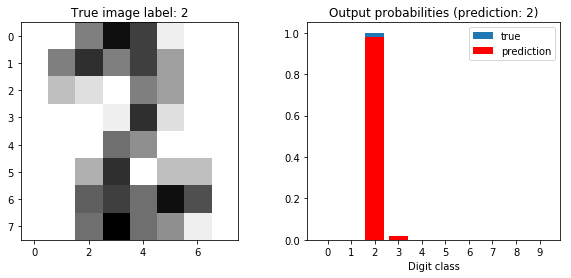

In [41]:
mlp_early_stopping.plot_validation_prediction(sample_id=42)

#### MLP with momentum

In [46]:
mlp_with_momentum = MultiLayerPerceptron(
    X, Y, hidden_size=50, 
    activation='relu', 
    dropout=False, 
    dropout_rate=0
)
mlp_with_momentum.train(
    optimizer='sgd',
    momentum=True,
    min_iterations=500,
    max_iterations=5000,
    initial_step=1e-1,
    batch_size=64,
    early_stopping=True,
    early_stopping_lookbehind=100,
    early_stopping_delta=1e-4, 
    vectorized=True,
    verbose=True
)
print("**MLP with momentum**")
print("Training accuracy: {:.4f}".format(mlp_with_momentum.accuracy_on_train()))
print("Validation accuracy: {:.4f}".format(mlp_with_momentum.accuracy_on_validation()))
print("Training loss: {:.4f}".format(mlp_with_momentum.training_losses_history[-1]))
print("Validation loss: {:.4f}".format(mlp_with_momentum.validation_losses_history[-1]))
print("Number of iterations: {:d}".format(len(mlp_with_momentum.training_losses_history)))

iteration number: 1	 training loss: 2.3026	validation loss: 2.3026	 validation accuracy: 0.0911
iteration number: 2	 training loss: 2.3025	validation loss: 2.3027	 validation accuracy: 0.0911
iteration number: 3	 training loss: 2.3023	validation loss: 2.3029	 validation accuracy: 0.0689
iteration number: 4	 training loss: 2.3022	validation loss: 2.3030	 validation accuracy: 0.0689
iteration number: 5	 training loss: 2.3020	validation loss: 2.3034	 validation accuracy: 0.1511
iteration number: 6	 training loss: 2.3018	validation loss: 2.3036	 validation accuracy: 0.1400
iteration number: 7	 training loss: 2.3017	validation loss: 2.3038	 validation accuracy: 0.0689
iteration number: 8	 training loss: 2.3016	validation loss: 2.3039	 validation accuracy: 0.0689
iteration number: 9	 training loss: 2.3014	validation loss: 2.3040	 validation accuracy: 0.0711
iteration number: 10	 training loss: 2.3013	validation loss: 2.3044	 validation accuracy: 0.0689
iteration number: 11	 training loss: 2.

iteration number: 99	 training loss: 0.2205	validation loss: 0.2293	 validation accuracy: 0.9244
iteration number: 100	 training loss: 0.2267	validation loss: 0.2404	 validation accuracy: 0.9311
iteration number: 101	 training loss: 0.2284	validation loss: 0.2437	 validation accuracy: 0.9311
iteration number: 102	 training loss: 0.2205	validation loss: 0.2404	 validation accuracy: 0.9333
iteration number: 103	 training loss: 0.2121	validation loss: 0.2365	 validation accuracy: 0.9333
iteration number: 104	 training loss: 0.1913	validation loss: 0.2171	 validation accuracy: 0.9400
iteration number: 105	 training loss: 0.1797	validation loss: 0.2078	 validation accuracy: 0.9378
iteration number: 106	 training loss: 0.1854	validation loss: 0.2176	 validation accuracy: 0.9356
iteration number: 107	 training loss: 0.2062	validation loss: 0.2478	 validation accuracy: 0.9089
iteration number: 108	 training loss: 0.2229	validation loss: 0.2726	 validation accuracy: 0.9022
iteration number: 109

iteration number: 190	 training loss: 0.0948	validation loss: 0.1227	 validation accuracy: 0.9644
iteration number: 191	 training loss: 0.0910	validation loss: 0.1163	 validation accuracy: 0.9689
iteration number: 192	 training loss: 0.0880	validation loss: 0.1099	 validation accuracy: 0.9733
iteration number: 193	 training loss: 0.0862	validation loss: 0.1082	 validation accuracy: 0.9711
iteration number: 194	 training loss: 0.0879	validation loss: 0.1091	 validation accuracy: 0.9711
iteration number: 195	 training loss: 0.0884	validation loss: 0.1092	 validation accuracy: 0.9711
iteration number: 196	 training loss: 0.0873	validation loss: 0.1086	 validation accuracy: 0.9711
iteration number: 197	 training loss: 0.0860	validation loss: 0.1089	 validation accuracy: 0.9711
iteration number: 198	 training loss: 0.0864	validation loss: 0.1124	 validation accuracy: 0.9711
iteration number: 199	 training loss: 0.0871	validation loss: 0.1163	 validation accuracy: 0.9689
iteration number: 20

iteration number: 284	 training loss: 0.0591	validation loss: 0.1056	 validation accuracy: 0.9711
iteration number: 285	 training loss: 0.0562	validation loss: 0.1012	 validation accuracy: 0.9711
iteration number: 286	 training loss: 0.0546	validation loss: 0.1004	 validation accuracy: 0.9733
iteration number: 287	 training loss: 0.0531	validation loss: 0.1002	 validation accuracy: 0.9756
iteration number: 288	 training loss: 0.0534	validation loss: 0.1013	 validation accuracy: 0.9778
iteration number: 289	 training loss: 0.0525	validation loss: 0.1011	 validation accuracy: 0.9778
iteration number: 290	 training loss: 0.0507	validation loss: 0.0989	 validation accuracy: 0.9778
iteration number: 291	 training loss: 0.0481	validation loss: 0.0968	 validation accuracy: 0.9756
iteration number: 292	 training loss: 0.0481	validation loss: 0.0989	 validation accuracy: 0.9711
iteration number: 293	 training loss: 0.0500	validation loss: 0.1044	 validation accuracy: 0.9667
iteration number: 29

iteration number: 386	 training loss: 0.0340	validation loss: 0.0831	 validation accuracy: 0.9756
iteration number: 387	 training loss: 0.0335	validation loss: 0.0831	 validation accuracy: 0.9778
iteration number: 388	 training loss: 0.0332	validation loss: 0.0838	 validation accuracy: 0.9733
iteration number: 389	 training loss: 0.0335	validation loss: 0.0864	 validation accuracy: 0.9711
iteration number: 390	 training loss: 0.0339	validation loss: 0.0889	 validation accuracy: 0.9711
iteration number: 391	 training loss: 0.0343	validation loss: 0.0916	 validation accuracy: 0.9711
iteration number: 392	 training loss: 0.0340	validation loss: 0.0951	 validation accuracy: 0.9733
iteration number: 393	 training loss: 0.0339	validation loss: 0.0976	 validation accuracy: 0.9756
iteration number: 394	 training loss: 0.0334	validation loss: 0.0983	 validation accuracy: 0.9756
iteration number: 395	 training loss: 0.0337	validation loss: 0.0997	 validation accuracy: 0.9756
iteration number: 39

iteration number: 479	 training loss: 0.0337	validation loss: 0.1042	 validation accuracy: 0.9711
iteration number: 480	 training loss: 0.0368	validation loss: 0.1087	 validation accuracy: 0.9689
iteration number: 481	 training loss: 0.0378	validation loss: 0.1101	 validation accuracy: 0.9689
iteration number: 482	 training loss: 0.0372	validation loss: 0.1078	 validation accuracy: 0.9667
iteration number: 483	 training loss: 0.0343	validation loss: 0.1014	 validation accuracy: 0.9644
iteration number: 484	 training loss: 0.0329	validation loss: 0.0974	 validation accuracy: 0.9689
iteration number: 485	 training loss: 0.0318	validation loss: 0.0945	 validation accuracy: 0.9711
iteration number: 486	 training loss: 0.0317	validation loss: 0.0928	 validation accuracy: 0.9756
iteration number: 487	 training loss: 0.0284	validation loss: 0.0890	 validation accuracy: 0.9800
iteration number: 488	 training loss: 0.0258	validation loss: 0.0861	 validation accuracy: 0.9822
iteration number: 48

iteration number: 566	 training loss: 0.0207	validation loss: 0.0863	 validation accuracy: 0.9800
iteration number: 567	 training loss: 0.0205	validation loss: 0.0864	 validation accuracy: 0.9800
iteration number: 568	 training loss: 0.0205	validation loss: 0.0868	 validation accuracy: 0.9800
iteration number: 569	 training loss: 0.0206	validation loss: 0.0871	 validation accuracy: 0.9800
iteration number: 570	 training loss: 0.0209	validation loss: 0.0876	 validation accuracy: 0.9778
iteration number: 571	 training loss: 0.0209	validation loss: 0.0885	 validation accuracy: 0.9756
iteration number: 572	 training loss: 0.0211	validation loss: 0.0916	 validation accuracy: 0.9778
iteration number: 573	 training loss: 0.0214	validation loss: 0.0927	 validation accuracy: 0.9778
iteration number: 574	 training loss: 0.0221	validation loss: 0.0938	 validation accuracy: 0.9711
iteration number: 575	 training loss: 0.0228	validation loss: 0.0946	 validation accuracy: 0.9756
iteration number: 57

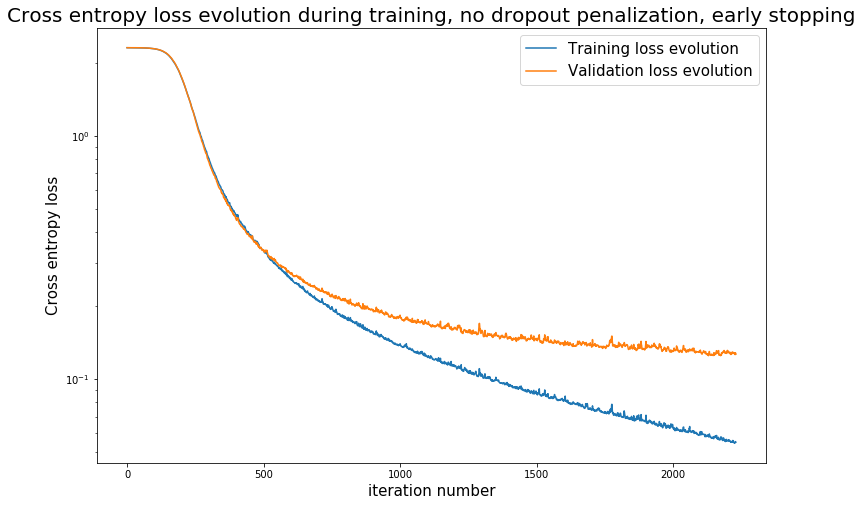

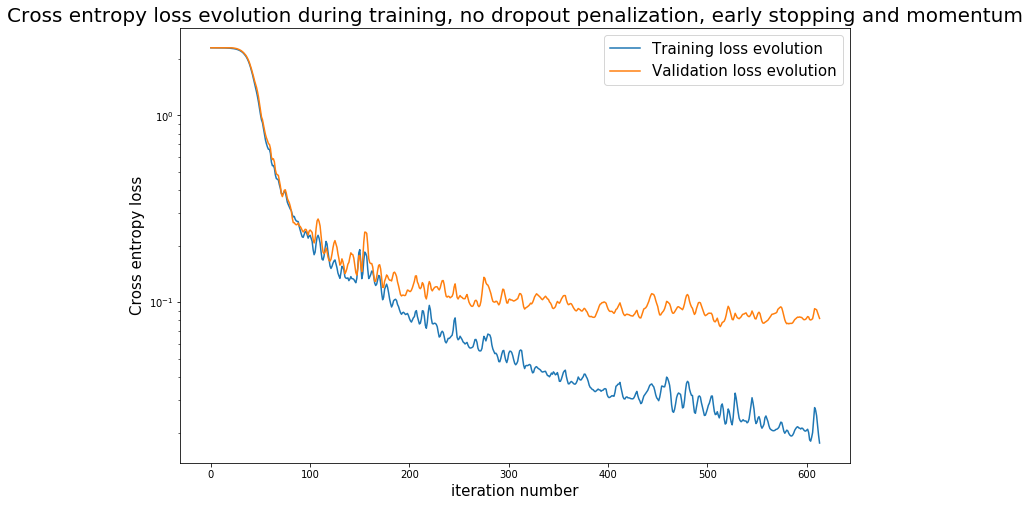

In [47]:
mlp_early_stopping.plot_loss_history(add_to_title="early stopping")
mlp_with_momentum.plot_loss_history(add_to_title="early stopping and momentum")

#### Comparing without and with dropout

In [63]:
mlp_without_dropout = MultiLayerPerceptron(
    X, Y, hidden_size=50, 
    activation='relu', 
    dropout=False
)
mlp_without_dropout.train(
    optimizer='sgd',
    min_iterations=500,
    max_iterations=5000,
    initial_step=1e-1,
    batch_size=64,
    early_stopping=True,
    early_stopping_lookbehind=100,
    early_stopping_delta=1e-4, 
    vectorized=True,
    verbose=False
)
print("**MLP without early stopping nor dropout**")
print("Training accuracy: {:.4f}".format(mlp_without_dropout.accuracy_on_train()))
print("Validation accuracy: {:.4f}".format(mlp_without_dropout.accuracy_on_validation()))
print("Training loss: {:.4f}".format(mlp_without_dropout.training_losses_history[-1]))
print("Validation loss: {:.4f}".format(mlp_without_dropout.validation_losses_history[-1]))

**MLP without early stopping nor dropout**
Training accuracy: 0.9807
Validation accuracy: 0.9600
Training loss: 0.0839
Validation loss: 0.1496


In [78]:
mlp_with_dropout = MultiLayerPerceptron(
    X, Y, hidden_size=50,
    activation='relu',
    dropout=True,
    dropout_rate=0.25
)
mlp_with_dropout.train(
    optimizer='sgd',
    min_iterations=500,
    max_iterations=5000,
    initial_step=1e-1,
    batch_size=64,
    early_stopping=True,
    early_stopping_lookbehind=100,
    early_stopping_delta=1e-4, 
    vectorized=True,
    verbose=False
)
print("**MLP with dropout**")
print("Training accuracy: {:.4f}".format(mlp_with_dropout.accuracy_on_train()))
print("Validation accuracy: {:.4f}".format(mlp_with_dropout.accuracy_on_validation()))
print("Training loss: {:.4f}".format(mlp_with_dropout.training_losses_history[-1]))
print("Validation loss: {:.4f}".format(mlp_with_dropout.validation_losses_history[-1]))

**MLP with dropout**
Training accuracy: 0.9688
Validation accuracy: 0.9667
Training loss: 0.1013
Validation loss: 0.1353


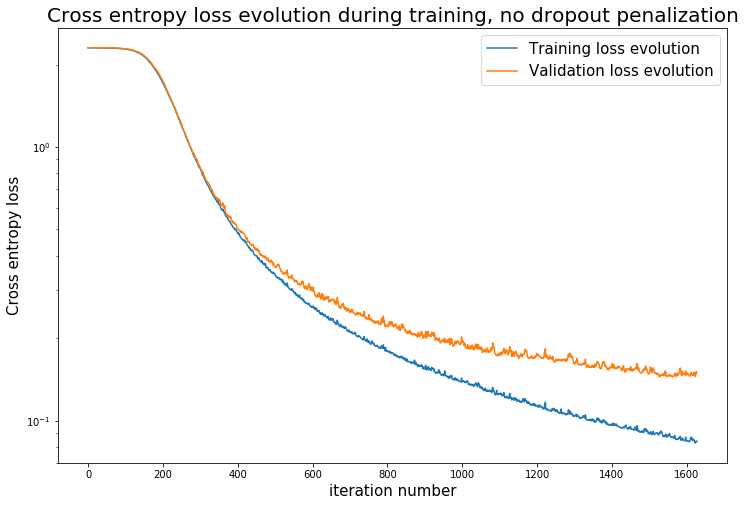

In [79]:
mlp_without_dropout.plot_loss_history()

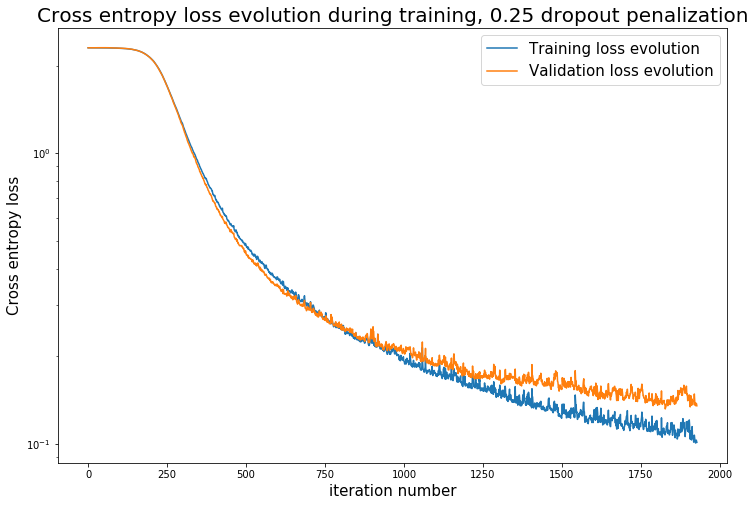

In [80]:
mlp_with_dropout.plot_loss_history()

# III - Multiclass classification MLP with Keras

#### - Implement the same network architecture with Keras;
    - First using the Sequential API
    - Secondly using the functional API

#### - Check that the Keras model can approximately reproduce the behavior of the Numpy model.

#### - Compute the negative log likelihood of a sample 42 in the validation set (can use `model.predict_proba`).

#### - Compute the average negative log-likelihood on the full validation set.

#### - Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

#### - Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 500 or more if necessary).

In [15]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

In [16]:
n_features = X[0].shape[0]
n_classes = len(np.unique(Y_tr))
n_hidden = 10

### Sequential

In [17]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))
keras_model = Sequential()
keras_model.add(Dense(n_hidden, input_dim=n_features, activation=activation))
keras_model.add(Dense(n_classes, activation='softmax'))
keras_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
keras_model.fit(
    X_tr, to_categorical(Y_tr, num_classes=n_classes),
    epochs=100, batch_size=32, verbose=1,
    validation_data=(X_val, to_categorical(Y_val, num_classes=n_classes))
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/100
1347/1347 [==============================] - 0s 149us/step - loss: 2.3828 - acc: 0.0839 - val_loss: 2.2774 - val_acc: 0.1733
Epoch 2/100
1347/1347 [==============================] - 0s 35us/step - loss: 2.2363 - acc: 0.1886 - val_loss: 2.1684 - val_acc: 0.2533
Epoch 3/100
1347/1347 [==============================] - 0s 29us/step - loss: 2.1322 - acc: 0.2576 - val_loss: 2.0574 - val_acc: 0.3267
Epoch 4/100
1347/1347 [==============================] - 0s 31us/step - loss: 2.0183 - acc: 0.3267 - val_loss: 1.9365 - val_acc: 0.3800
Epoch 5/100
1347/1347 [==============================] - 0s 30us/step - loss: 1.8908 - acc: 0.3950 - val_loss: 1.8003 - val_acc: 0.5067
Epoch 6/100
1347/1347 [==============================] - 0s 29us/step - loss: 1.7473 - acc: 0.5145 - val_loss: 1.6506 - val_acc: 0.5756
Epoch 7/100
1347/1347 [==============================] - 0s 38us/step - loss: 1.5920 - acc: 0.5716 - val_loss

In [18]:
index_sample = 42

Y_val_one_hot_sample = to_categorical(Y_val[index_sample], num_classes=n_classes)
Y_val_pred_sample = np.squeeze(keras_model.predict_proba(np.expand_dims(X_val[index_sample], axis=0)))
nll_val_sample = -np.log(Y_val_one_hot_sample.dot(Y_val_pred_sample))
print("**Sample {:d}**".format(index_sample))
print("Negative loglikelihood: {:.7f}".format(nll_val_sample))

**Sample 42**
Negative loglikelihood: 0.0014035


In [19]:
Y_val_one_hot = to_categorical(Y_val, num_classes=n_classes)
Y_val_pred = keras_model.predict_proba(X_val)
nll_val = np.matmul(Y_val_one_hot.reshape(-1, 1, n_classes), Y_val_pred.reshape(-1, n_classes, 1))
nll_val = -np.mean(np.log(np.squeeze(nll_val)))
print("**Whole validation set**")
print("Negative loglikelihood: {:.7f}".format(nll_val))

**Whole validation set**
Negative loglikelihood: 0.1456044


In [20]:
Y_tr_one_hot = to_categorical(Y_tr, num_classes=n_classes)
Y_tr_pred = keras_model.predict_proba(X_tr)
nll_tr = np.matmul(Y_tr_one_hot.reshape(-1, 1, n_classes), Y_tr_pred.reshape(-1, n_classes, 1))
nll_tr = -np.mean(np.log(np.squeeze(nll_tr)))
print("**Whole training set**")
print("Our negative loglikelihood: {:.7f}".format(nll_tr))
keras_nll_tr = keras.losses.categorical_crossentropy(K.constant(Y_tr_one_hot), K.constant(Y_tr_pred))
keras_nll_tr = np.mean(K.eval(keras_nll_tr))
print("Keras negative loglikelihood: {:.7f}".format(keras_nll_tr))

**Whole training set**
Our negative loglikelihood: 0.0615000
Keras negative loglikelihood: 0.0615000


### Functional

In [21]:
from keras.layers import Input
from keras.models import Model

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))

inputs = Input(shape=(n_features,))
h_layer = Dense(n_hidden, activation=activation)(inputs)
y_layer = Dense(n_classes, activation='softmax')(h_layer)

model = Model(inputs=inputs, outputs=y_layer)
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    X_tr, to_categorical(Y_tr, num_classes=n_classes), 
    epochs=300, verbose=1, batch_size=32,
    validation_data=(X_val, to_categorical(Y_val, num_classes=n_classes))
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/300
1347/1347 [==============================] - 0s 170us/step - loss: 2.3759 - acc: 0.1039 - val_loss: 2.2631 - val_acc: 0.1711
Epoch 2/300
1347/1347 [==============================] - 0s 37us/step - loss: 2.1950 - acc: 0.2168 - val_loss: 2.1302 - val_acc: 0.2489
Epoch 3/300
1347/1347 [==============================] - 0s 28us/step - loss: 2.0650 - acc: 0.2947 - val_loss: 2.0116 - val_acc: 0.2956
Epoch 4/300
1347/1347 [==============================] - 0s 32us/step - loss: 1.9462 - acc: 0.3281 - val_loss: 1.8976 - val_acc: 0.3311
Epoch 5/300
1347/1347 [==============================] - 0s 32us/step - loss: 1.8272 - acc: 0.3808 - val_loss: 1.7785 - val_acc: 0.3956
Epoch 6/300
1347/1347 [==============================] - 0s 32us/step - loss: 1.6988 - acc: 0.4573 - val_loss: 1.6469 - val_acc: 0.4756
Epoch 7/300
1347/1347 [==============================] - 0s 29us/step - loss: 1.5531 - acc: 0.5241 - val_loss

Epoch 120/300
1347/1347 [==============================] - 0s 35us/step - loss: 0.0621 - acc: 0.9874 - val_loss: 0.1643 - val_acc: 0.9467
Epoch 121/300
1347/1347 [==============================] - 0s 32us/step - loss: 0.0609 - acc: 0.9874 - val_loss: 0.1633 - val_acc: 0.9467
Epoch 122/300
1347/1347 [==============================] - 0s 30us/step - loss: 0.0606 - acc: 0.9874 - val_loss: 0.1606 - val_acc: 0.9467
Epoch 123/300
1347/1347 [==============================] - 0s 32us/step - loss: 0.0600 - acc: 0.9881 - val_loss: 0.1595 - val_acc: 0.9444
Epoch 124/300
1347/1347 [==============================] - 0s 34us/step - loss: 0.0601 - acc: 0.9889 - val_loss: 0.1610 - val_acc: 0.9444
Epoch 125/300
1347/1347 [==============================] - 0s 31us/step - loss: 0.0590 - acc: 0.9889 - val_loss: 0.1615 - val_acc: 0.9444
Epoch 126/300
1347/1347 [==============================] - 0s 44us/step - loss: 0.0618 - acc: 0.9889 - val_loss: 0.1607 - val_acc: 0.9378
Epoch 127/300
1347/1347 [=========

1347/1347 [==============================] - 0s 35us/step - loss: 0.0184 - acc: 0.9985 - val_loss: 0.1531 - val_acc: 0.9467
Epoch 239/300
1347/1347 [==============================] - 0s 30us/step - loss: 0.0185 - acc: 0.9985 - val_loss: 0.1518 - val_acc: 0.9489
Epoch 240/300
1347/1347 [==============================] - 0s 32us/step - loss: 0.0184 - acc: 0.9985 - val_loss: 0.1500 - val_acc: 0.9511
Epoch 241/300
1347/1347 [==============================] - 0s 32us/step - loss: 0.0181 - acc: 0.9985 - val_loss: 0.1510 - val_acc: 0.9444
Epoch 242/300
1347/1347 [==============================] - 0s 34us/step - loss: 0.0175 - acc: 0.9985 - val_loss: 0.1524 - val_acc: 0.9467
Epoch 243/300
1347/1347 [==============================] - 0s 34us/step - loss: 0.0177 - acc: 0.9985 - val_loss: 0.1520 - val_acc: 0.9444
Epoch 244/300
1347/1347 [==============================] - 0s 33us/step - loss: 0.0176 - acc: 0.9985 - val_loss: 0.1527 - val_acc: 0.9511
Epoch 245/300
1347/1347 [=======================

#### Now that you know if the model is underfitting or overfitting:
<span style="color:green">
Underfitting case: model not complex enough (not enough parameters and depth) to learn dependencies between $X$ and $Y$<br/>
Overfitting case: model too complex, learns statistically pointless dependencies between $X_{tr}$ and $Y_{tr}$
</span>
#### - In case of underfitting, can you explain why ? Also change the structure of the 2 previous networks to cancell underfitting
#### - In case of overfitting, explain why and change the structure of the 2 previous networks to cancell the overfitting
<span style="color:green">
We can observe a slight case of overfitting here, with a gap of about 5% between the training and the validation accuracies.<br/>Adding a Dropout with a small $p$ rate can be thus considered.
</span>

### Sequential without overfitting

In [22]:
from keras.layers import Dropout

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))
keras_model = Sequential()
keras_model.add(Dense(n_hidden, input_dim=n_features, activation=activation))
keras_model.add(Dropout(0.1))
keras_model.add(Dense(n_classes, activation='softmax'))
keras_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
keras_model.fit(
    X_tr, to_categorical(Y_tr, num_classes=n_classes),
    epochs=300, batch_size=32, verbose=1,
    validation_data=(X_val, to_categorical(Y_val, num_classes=n_classes))
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/300
1347/1347 [==============================] - 0s 205us/step - loss: 2.3129 - acc: 0.1069 - val_loss: 2.2536 - val_acc: 0.1489
Epoch 2/300
1347/1347 [==============================] - 0s 32us/step - loss: 2.2161 - acc: 0.1782 - val_loss: 2.1620 - val_acc: 0.2533
Epoch 3/300
1347/1347 [==============================] - 0s 32us/step - loss: 2.0967 - acc: 0.2821 - val_loss: 2.0234 - val_acc: 0.3711
Epoch 4/300
1347/1347 [==============================] - 0s 32us/step - loss: 1.9307 - acc: 0.3823 - val_loss: 1.8425 - val_acc: 0.4689
Epoch 5/300
1347/1347 [==============================] - 0s 32us/step - loss: 1.7535 - acc: 0.4625 - val_loss: 1.6596 - val_acc: 0.5533
Epoch 6/300
1347/1347 [==============================] - 0s 35us/step - loss: 1.5866 - acc: 0.5434 - val_loss: 1.5003 - val_acc: 0.6333
Epoch 7/300
1347/1347 [==============================] - 0s 34us/step - loss: 1.4583 - acc: 0.6110 - val_loss

1347/1347 [==============================] - 0s 52us/step - loss: 0.3501 - acc: 0.8924 - val_loss: 0.2431 - val_acc: 0.9356
Epoch 61/300
1347/1347 [==============================] - 0s 39us/step - loss: 0.3348 - acc: 0.8879 - val_loss: 0.2420 - val_acc: 0.9356
Epoch 62/300
1347/1347 [==============================] - 0s 41us/step - loss: 0.3372 - acc: 0.8901 - val_loss: 0.2401 - val_acc: 0.9333
Epoch 63/300
1347/1347 [==============================] - 0s 31us/step - loss: 0.3443 - acc: 0.8879 - val_loss: 0.2367 - val_acc: 0.9378
Epoch 64/300
1347/1347 [==============================] - 0s 36us/step - loss: 0.3477 - acc: 0.8827 - val_loss: 0.2369 - val_acc: 0.9333
Epoch 65/300
1347/1347 [==============================] - 0s 31us/step - loss: 0.3572 - acc: 0.8790 - val_loss: 0.2330 - val_acc: 0.9400
Epoch 66/300
1347/1347 [==============================] - 0s 43us/step - loss: 0.3104 - acc: 0.9057 - val_loss: 0.2295 - val_acc: 0.9444
Epoch 67/300
1347/1347 [==============================

Epoch 120/300
1347/1347 [==============================] - 0s 36us/step - loss: 0.2192 - acc: 0.9347 - val_loss: 0.1664 - val_acc: 0.9511
Epoch 121/300
1347/1347 [==============================] - 0s 32us/step - loss: 0.2164 - acc: 0.9280 - val_loss: 0.1655 - val_acc: 0.9511
Epoch 122/300
1347/1347 [==============================] - 0s 34us/step - loss: 0.2352 - acc: 0.9258 - val_loss: 0.1691 - val_acc: 0.9489
Epoch 123/300
1347/1347 [==============================] - 0s 32us/step - loss: 0.2127 - acc: 0.9354 - val_loss: 0.1646 - val_acc: 0.9533
Epoch 124/300
1347/1347 [==============================] - 0s 31us/step - loss: 0.2310 - acc: 0.9280 - val_loss: 0.1673 - val_acc: 0.9467
Epoch 125/300
1347/1347 [==============================] - 0s 36us/step - loss: 0.2262 - acc: 0.9250 - val_loss: 0.1675 - val_acc: 0.9467
Epoch 126/300
1347/1347 [==============================] - 0s 32us/step - loss: 0.2382 - acc: 0.9258 - val_loss: 0.1636 - val_acc: 0.9489
Epoch 127/300
1347/1347 [=========

1347/1347 [==============================] - 0s 38us/step - loss: 0.1584 - acc: 0.9510 - val_loss: 0.1247 - val_acc: 0.9533
Epoch 239/300
1347/1347 [==============================] - 0s 41us/step - loss: 0.1784 - acc: 0.9369 - val_loss: 0.1272 - val_acc: 0.9533
Epoch 240/300
1347/1347 [==============================] - 0s 42us/step - loss: 0.1557 - acc: 0.9421 - val_loss: 0.1244 - val_acc: 0.9533
Epoch 241/300
1347/1347 [==============================] - 0s 59us/step - loss: 0.1662 - acc: 0.9421 - val_loss: 0.1276 - val_acc: 0.9511
Epoch 242/300
1347/1347 [==============================] - 0s 42us/step - loss: 0.1669 - acc: 0.9436 - val_loss: 0.1310 - val_acc: 0.9511
Epoch 243/300
1347/1347 [==============================] - 0s 59us/step - loss: 0.1627 - acc: 0.9473 - val_loss: 0.1247 - val_acc: 0.9489
Epoch 244/300
1347/1347 [==============================] - 0s 36us/step - loss: 0.1673 - acc: 0.9436 - val_loss: 0.1234 - val_acc: 0.9511
Epoch 245/300
1347/1347 [=======================

### Functional without overfitting

In [29]:
activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))

inputs = Input(shape=(n_features,))
h_layer = Dense(n_hidden, activation=activation)(inputs)
h_layer_dropout = Dropout(0.1)(h_layer)
y_layer = Dense(n_classes, activation='softmax')(h_layer_dropout)

model = Model(inputs=inputs, outputs=y_layer)
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    X_tr, to_categorical(Y_tr, num_classes=n_classes), 
    epochs=300, verbose=1, batch_size=32,
    validation_data=(X_val, to_categorical(Y_val, num_classes=n_classes))
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/300
1347/1347 [==============================] - 0s 227us/step - loss: 2.2965 - acc: 0.1314 - val_loss: 2.2107 - val_acc: 0.1889
Epoch 2/300
1347/1347 [==============================] - 0s 43us/step - loss: 2.1783 - acc: 0.1982 - val_loss: 2.1019 - val_acc: 0.2244
Epoch 3/300
1347/1347 [==============================] - 0s 43us/step - loss: 2.0653 - acc: 0.2509 - val_loss: 1.9783 - val_acc: 0.3067
Epoch 4/300
1347/1347 [==============================] - 0s 32us/step - loss: 1.9338 - acc: 0.3252 - val_loss: 1.8308 - val_acc: 0.3622
Epoch 5/300
1347/1347 [==============================] - 0s 42us/step - loss: 1.7841 - acc: 0.4143 - val_loss: 1.6727 - val_acc: 0.4956
Epoch 6/300
1347/1347 [==============================] - 0s 43us/step - loss: 1.6374 - acc: 0.4751 - val_loss: 1.5140 - val_acc: 0.5844
Epoch 7/300
1347/1347 [==============================] - 0s 39us/step - loss: 1.4820 - acc: 0.5486 - val_loss

Epoch 120/300
1347/1347 [==============================] - 0s 36us/step - loss: 0.1784 - acc: 0.9406 - val_loss: 0.1442 - val_acc: 0.9511
Epoch 121/300
1347/1347 [==============================] - 0s 38us/step - loss: 0.1803 - acc: 0.9384 - val_loss: 0.1413 - val_acc: 0.9533
Epoch 122/300
1347/1347 [==============================] - 0s 33us/step - loss: 0.1828 - acc: 0.9428 - val_loss: 0.1404 - val_acc: 0.9533
Epoch 123/300
1347/1347 [==============================] - 0s 35us/step - loss: 0.2018 - acc: 0.9362 - val_loss: 0.1438 - val_acc: 0.9511
Epoch 124/300
1347/1347 [==============================] - 0s 31us/step - loss: 0.1750 - acc: 0.9421 - val_loss: 0.1428 - val_acc: 0.9511
Epoch 125/300
1347/1347 [==============================] - 0s 35us/step - loss: 0.2006 - acc: 0.9354 - val_loss: 0.1459 - val_acc: 0.9511
Epoch 126/300
1347/1347 [==============================] - 0s 35us/step - loss: 0.1865 - acc: 0.9391 - val_loss: 0.1535 - val_acc: 0.9444
Epoch 127/300
1347/1347 [=========

1347/1347 [==============================] - 0s 34us/step - loss: 0.1361 - acc: 0.9532 - val_loss: 0.1265 - val_acc: 0.9578
Epoch 239/300
1347/1347 [==============================] - 0s 33us/step - loss: 0.1390 - acc: 0.9495 - val_loss: 0.1325 - val_acc: 0.9489
Epoch 240/300
1347/1347 [==============================] - 0s 37us/step - loss: 0.1369 - acc: 0.9577 - val_loss: 0.1297 - val_acc: 0.9533
Epoch 241/300
1347/1347 [==============================] - 0s 39us/step - loss: 0.1318 - acc: 0.9577 - val_loss: 0.1294 - val_acc: 0.9533
Epoch 242/300
1347/1347 [==============================] - 0s 35us/step - loss: 0.1178 - acc: 0.9659 - val_loss: 0.1230 - val_acc: 0.9556
Epoch 243/300
1347/1347 [==============================] - 0s 34us/step - loss: 0.1345 - acc: 0.9488 - val_loss: 0.1269 - val_acc: 0.9533
Epoch 244/300
1347/1347 [==============================] - 0s 35us/step - loss: 0.1527 - acc: 0.9465 - val_loss: 0.1296 - val_acc: 0.9533
Epoch 245/300
1347/1347 [=======================